# Quelques prises de notes

## Traitement de données

- **Regarder le taux de remplissage de certains pays** + Ne pas hésiter à supprimer des trop petits pays du DataFrame  
- **Le remplissage doit être complet pour la quasi totalité des pays** -> Filtre population minimale

## Analyse de données

- Proposer une liste de pays qui répond le mieux aux critères demandés  
(Seuil minimum pour une variable ou pour des variables combinés)
- Créer un score d'attractivité par pays  

1) Quels sont les pays avec un fort potentiel de clients pour nos services ?
2) Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
3) Dans quels pays l'entreprise doit-elle opérer en priorité ?

NORME ISO -> reperer les pays qui sont intéréssants (telecharger les pays de la norme ISO et comparer)   
Github -> Je récupererai ca par mail
Graphique radar pour les pays -> Top 10-15 

- Doit montrer un bon potentiel
- Doit montrer une évolution de ce potentiel
- Le pays doit être grand (indicateur de population?)

## Questions au Mentor

- Je peux changer le nom des csv? (Passer de EdStatsCountry-Series.csv à EdStatsCountrySeries.csv) -> Oui
- "Data sources : United Nations World Population" important ou pas? -> Non

-> Regarder le taux de remplissage + Supprimer les petits pays?

EdStatsFootNote -> Déploiment internet? -> Grand marché si valeur basse
PIB, PIB hab, revenus, indicateurs economiques... 

Seaborn -> Heatmap -> Mieux voir les indicateurs qui pourraient m'intéresser


# Imports et configs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pingouin as pg
from scipy.stats import pearsonr
import scipy.stats as stats

In [2]:
EdStatsCountry = pd.read_csv("./Data/EdStatsCountry.csv")
EdStatsCountrySeries = pd.read_csv("./Data/EdStatsCountrySeries.csv")
EdStatsData = pd.read_csv("./Data/EdStatsData.csv")
EdStatsFootNote = pd.read_csv("./Data/EdStatsFootNote.csv")
EdStatsSeries = pd.read_csv("./Data/EdStatsSeries.csv")
ISO3166PlusUnStatistics = pd.read_csv("./Data/ISO-3166-Countries+UN-Statistics.csv")

ISO3166PlusUnStatistics -> Listes de pays et de territoires dépendants ISO-3166 avec codes régionaux de l'ONU
Ces listes sont le résultat de la fusion de données provenant de deux sources, l'article ISO 3166-1 de Wikipedia pour les codes de pays alpha et numériques, et le site des statistiques de l'ONU pour les codes régionaux et sous-régionaux des pays. En plus des pays, il inclut les territoires dépendants.  

Récupéré de Github: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes

In [3]:
# Pour augmenter le nb max de lignes affichable
# pd.set_option('display.max_rows', 10)

pd.options.display.max_colwidth = 500
pd.options.display.width = 200

#.info()
# .describe()
# .dtypes()

# Fonctions (pour ne pas alourdir le fichier)

Cette fonction calcule le taux de remplissage pour une colonne en comptant le nombre de valeurs non nulles pour chaque groupe d'indicateurs, puis renvoie le nombre de pays et le nom de l'indicateur triés par nombre de pays.

In [4]:
def calculate_fill_rate(df):
    # vérifier les valeurs non nulles dans la colonne "Annees 2010"
    notnull_mask = df["Annees 2010"].notnull()

    # sélectionner les colonnes "Indicator Name" et "Indicator Code" pour inclure dans le résultat
    mask = df[["Indicator Name", "Indicator Code"]][notnull_mask]

    # grouper les données par "Indicator Code" et compter le nombre de valeurs non nulles pour chaque groupe
    result = mask.groupby(["Indicator Code", "Indicator Name"]).size().reset_index(name='NbDePays')

    result["Taux de remplissage"] = 100 * result["NbDePays"] / df.drop_duplicates(subset="Country Name").shape[0]

    # afficher le nombre de pays pour chaque groupe ainsi que le nom de l'indicateur
    return result.sort_values("NbDePays", ascending=False)

Cette fonction calcule la matrice de corrélation et la matrice de p-value pour une table pivot en utilisant la fonction pearsonr de scipy.stats, puis retourne les matrices en tant que DataFrames.

In [5]:
def calculate_correlation_matrix(pivot_table):
    X = pivot_table.shape[1]
    pivot_array = pivot_table.values
    corr_matrix = np.zeros((X, X))
    p_matrix = np.zeros((X, X))

    for i in range(X):
        for j in range(X):
            corr, p_value = stats.pearsonr(pivot_array[:, i], pivot_array[:, j])
            corr_matrix[i, j] = corr
            p_matrix[i, j] = p_value

    corr_matrix = pd.DataFrame(corr_matrix, columns=pivot_table.columns, index=pivot_table.columns)
    p_matrix = pd.DataFrame(p_matrix, columns=pivot_table.columns, index=pivot_table.columns)

    return corr_matrix, p_matrix

Cette fonction trouve les indicateurs corrélés dans une table pivot en comparant la corrélation et la p-value pour chaque couple de colonnes, puis retourne les indicateurs corrélés dans un DataFrame.

In [6]:
def find_correlated_indicators(pivot_table, corr_matrix, p_matrix):
    correlated_indicators = []
    for i in range(pivot_table.shape[1]):
        for j in range(i, pivot_table.shape[1]):
            p_value = p_matrix.iloc[i, j]
            corr = corr_matrix.iloc[i, j]
            if  ((corr >= 0.7 and corr <= 1) or (corr >= -1 and corr <= -0.7)) and (p_value < 0.05):
                correlated_indicators.append((pivot_table.columns[i], pivot_table.columns[j], corr, p_value))
    return pd.DataFrame(correlated_indicators, columns=['Indicateur A', 'Indicateur B', 'Correlation', 'P-Value'])

Cette fonction trouve l'indicateur le moins corrélé en comptant le nombre de fois qu'il apparaît dans les données, puis retourne les indicateurs correspondants dans un sous-ensemble des données.

In [7]:
def find_least_correlated_indicator(Correlation, taux):
    counts = Correlation['Indicateur A'].value_counts()
    min_count = counts.min()
    least_repeated_indicators = counts[counts == min_count].index

    mask = Correlation["Indicateur A"].isin(least_repeated_indicators)
    display(Correlation[mask])

    indicator_codes = taux[taux["Indicator Code"].isin(Correlation[mask]["Indicateur A"]) | taux["Indicator Code"].isin(
        Correlation[mask]["Indicateur B"])]["Indicator Code"].unique()
    indicateurs = taux[taux["Indicator Code"].isin(indicator_codes)]
    return indicateurs

Cette fonction extrapole une courbe selon un ordre polynomial X

In [8]:
def extrapolate_values(X):
    years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
    extrapolation = [2017, 2020, 2030, 2040, 2050]

    extrapolated_values = []
    for i, row in df.iterrows():
        values = row.values
        coefficients = np.polyfit(years, values, X)
        extrapolated = np.polyval(coefficients, extrapolation)
        extrapolated = [0 if x < 0 else x for x in extrapolated]
        extrapolated_values.append(extrapolated)

    linear_df = pd.DataFrame(extrapolated_values, columns=extrapolation, index=df.index)

    return pd.concat([df, linear_df], axis=1)

# Traitement

## EdStatsCountry

Informations générales sur les pays

In [9]:
EdStatsCountry

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from official government statistics; 1994-1999 from UN databases. Base year has changed from 1995 to 2000.,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period for national accounts data: FY (from 2013 are CY). National accounts data are sourced from the IMF and differ from the Central Statistics Organization numbers due to exclusion of the opium economy.,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data, national accounts data were revised for 2000 onward; the base year changed to 2002.",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN
3,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09","Living Standards Measurement Study Survey (LSMS), 2012",Yes,2012,2010.0,2012.0,2006,NaN
4,AND,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,...,NaN,2011. Population figures compiled from administrative registers.,NaN,NaN,Yes,NaN,NaN,2006.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,XKX,Kosovo,Kosovo,Republic of Kosovo,NaN,Euro,"Kosovo became a World Bank member on June 29, 2009. Since 1999, Kosovo has been a territory under international administration pursuant to UN Security Council Resolution 1244 (1999).",Europe & Central Asia,Lower middle income,KV,...,General Data Dissemination System (GDDS),2011,NaN,"Integrated household survey (IHS), 2011",NaN,NaN,NaN,NaN,NaN,NaN
237,YEM,Yemen,"Yemen, Rep.",Republic of Yemen,YE,Yemeni rial,"Based on official government statistics and International Monetary Fund data, national accounts data have been revised for 1990 onward.",Middle East & North Africa,Lower middle income,RY,...,General Data Dissemination System (GDDS),2004,"Demographic and Health Survey (DHS), 2013","Expenditure survey/budget survey (ES/BS), 2005",NaN,NaN,2006.0,2012.0,2005,NaN
238,ZAF,South Africa,South Africa,Republic of South Africa,ZA,South African rand,Fiscal year end: March 31; reporting period for national accounts data: CY.,Sub-Saharan Africa,Upper middle income,ZA,...,Special Data Dissemination Standard (SDDS),2011,"Demographic and Health Survey (DHS), 2003; World Health Survey (WHS), 2003","Expenditure survey/budget survey (ES/BS), 2010",NaN,2007,2010.0,2012.0,2000,NaN
239,ZMB,Zambia,Zambia,Republic of Zambia,ZM,New Zambian kwacha,"National accounts data have rebased to reflect the January 1, 2013, introduction of the new Zambian kwacha at a rate of 1,000 old kwacha = 1 new kwacha.",Sub-Saharan Africa,Lower middle income,ZM,...,General Data Dissemination System (GDDS),2010,"Demographic and Health Survey (DHS), 2013","Integrated household survey (IHS), 2010",NaN,2010. Population and Housing Census.,NaN,2011.0,2002,NaN


---
 <b><center><span style="font-size: 25px;"><font color="red">241 rows -> Apparament 241 Pays -> Y'a t'il des doublons?</font></span></center></b> 

In [10]:
EdStatsCountry.loc[EdStatsCountry['Country Code'].duplicated(keep=False),:]

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31


  <b><center><span style="font-size: 25px;"><font color="#90EE90">0 Doublons -> 241 Pays pour EdStatsCountry </font></span></center></b> 

---

  <b><center><span style="font-size: 25px;"><font color="red">Ces zones s'ont ils dans la liste ISO 3166?</font></span></center></b> 

In [11]:
ISO3166PlusUnStatistics

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NaN,9.0,61.0,NaN
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NaN,2.0,15.0,NaN
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0


In [12]:
mask = EdStatsCountry["Country Code"].isin(ISO3166PlusUnStatistics["alpha-3"])
EdStatsCountry[~mask]["Table Name"]

5                                          Arab World
35                                    Channel Islands
57                                East Asia & Pacific
58            East Asia & Pacific (all income levels)
59                              Europe & Central Asia
60          Europe & Central Asia (all income levels)
63                                          Euro area
68                                     European Union
89                                        High income
92             Heavily indebted poor countries (HIPC)
116                         Latin America & Caribbean
122     Latin America & Caribbean (all income levels)
123      Least developed countries: UN classification
124                                        Low income
127                               Lower middle income
128                               Low & middle income
140    Middle East & North Africa (all income levels)
143                                     Middle income
148                        M

In [13]:
mask2 = ISO3166PlusUnStatistics["alpha-3"].isin(EdStatsCountry["Country Code"])
ISO3166PlusUnStatistics["name"][~mask2]

1                                     Åland Islands
7                                          Anguilla
8                                        Antarctica
27                 Bonaire, Sint Eustatius and Saba
30                                    Bouvet Island
32                   British Indian Ocean Territory
46                                 Christmas Island
47                          Cocos (Keeling) Islands
52                                     Cook Islands
72                      Falkland Islands (Malvinas)
77                                    French Guiana
79                      French Southern Territories
89                                       Guadeloupe
92                                         Guernsey
97                Heard Island and McDonald Islands
98                                         Holy See
113                                          Jersey
139                                      Martinique
142                                         Mayotte
149         

In [14]:
mask = EdStatsCountry["Country Code"].isin(ISO3166PlusUnStatistics["alpha-3"])
EdStatsCountry = EdStatsCountry[mask]
EdStatsCountry

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from official government statistics; 1994-1999 from UN databases. Base year has changed from 1995 to 2000.,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period for national accounts data: FY (from 2013 are CY). National accounts data are sourced from the IMF and differ from the Central Statistics Organization numbers due to exclusion of the opium economy.,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data, national accounts data were revised for 2000 onward; the base year changed to 2002.",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN
3,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09","Living Standards Measurement Study Survey (LSMS), 2012",Yes,2012,2010.0,2012.0,2006,NaN
4,AND,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,...,NaN,2011. Population figures compiled from administrative registers.,NaN,NaN,Yes,NaN,NaN,2006.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,WSM,Samoa,Samoa,Samoa,WS,Samoan tala,Fiscal year ends on June 30; reporting period for national accounts data: FY. Data are revised from Samoa Bureau of Statistics and Central Bank of Samoa.,East Asia & Pacific,Lower middle income,WS,...,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2009",NaN,NaN,2009,NaN,2012.0,NaN,NaN
237,YEM,Yemen,"Yemen, Rep.",Republic of Yemen,YE,Yemeni rial,"Based on official government statistics and International Monetary Fund data, national accounts data have been revised for 1990 onward.",Middle East & North Africa,Lower middle income,RY,...,General Data Dissemination System (GDDS),2004,"Demographic and Health Survey (DHS), 2013","Expenditure survey/budget survey (ES/BS), 2005",NaN,NaN,2006.0,2012.0,2005,NaN
238,ZAF,South Africa,South Africa,Republic of South Africa,ZA,South African rand,Fiscal year end: March 31; reporting period for national accounts data: CY.,Sub-Saharan Africa,Upper middle income,ZA,...,Special Data Dissemination Standard (SDDS),2011,"Demographic and Health Survey (DHS), 2003; World Health Survey (WHS), 2003","Expenditure survey/budget survey (ES/BS), 2010",NaN,2007,2010.0,2012.0,2000,NaN
239,ZMB,Zambia,Zambia,Republic of Zambia,ZM,New Zambian kwacha,"National accounts data have rebased to reflect the January 1, 2013, introduction of the new Zambian kwacha at a rate of 1,000 old kwacha = 1 new kwacha.",Sub-Saharan Africa,Lower middle income,ZM,...,General Data Dissemination System (GDDS),2010,"Demographic and Health Survey (DHS), 2013","Integrated household survey (IHS), 2010",NaN,2010. Population and Housing Census.,NaN,2011.0,2002,NaN


<b><center><span style="font-size: 25px;"><font color="#90EE90">EdStatsCountry ne possède plus que 208 pays</font></span></center></b> 

  <b><center><span style="font-size: 25px;"><font color="red">Y'a t'il des colonnes ne possédant que des "NaN"?</font></span></center></b> 


In [15]:
# Vérifie toutes les colonnes et donne un "true" ou "false" en fonction de la situation
all_na_cols = EdStatsCountry.isna().all()

# Ne donne que les colonnes ne possèdant uniquement que des "Nan"
na_cols = EdStatsCountry.loc[:, all_na_cols].columns

print(na_cols)

Index(['Unnamed: 31'], dtype='object')


<b><center><span style="font-size: 25px;"><font color="#90EE90">Unnamed: 31 ne possède que des Nan -> On va la supprimer </font></span></center></b> 

In [16]:
EdStatsCountry = EdStatsCountry.drop(['Unnamed: 31'], axis=1)

---

  <b><center><span style="font-size: 25px;"><font color="red">Combien de "Nan" pour chaque colonne?</font></span></center></b> 

In [17]:
EdStatsCountry.isnull().sum().sort_values(ascending=False)

National accounts reference year                     183
Alternative conversion factor                        167
Other groups                                         156
Latest industrial data                               107
Vital registration complete                          104
Special Notes                                         95
External debt Reporting status                        91
Latest household survey                               73
Latest agricultural census                            72
Lending category                                      71
PPP survey year                                       69
Source of most recent Income and expenditure data     55
Government Accounting concept                         53
Latest water withdrawal data                          35
IMF data dissemination standard                       34
Balance of Payments Manual in use                     33
Latest trade data                                     29
SNA price valuation            

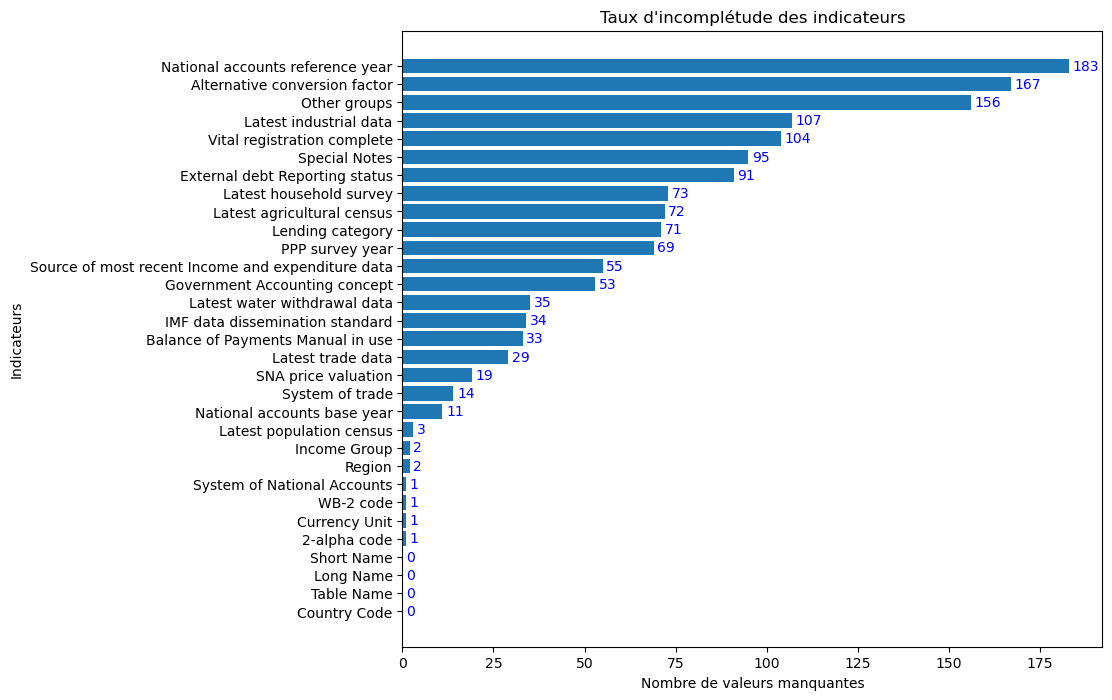

In [18]:
# Créer un dictionnaire contenant les indicateurs et le nombre de valeurs manquantes pour chaque indicateur
data = EdStatsCountry.isnull().sum().sort_values(ascending=False)

# Inverser l'ordre des éléments dans les listes keys et vals
keys = list(data.keys())[::-1]
vals = list(data.values)[::-1]

# Créer un tableau d'étiquettes pour l'axe des abscisses
x_labels = [str(i) for i, key in enumerate(keys, 1)]

# Créer une figure plus grande pour le graphique
plt.figure(figsize=(10, 8))

# Créer le graphique à barres horizontal
plt.barh(keys, vals)

# Ajouter des étiquettes aux axes x et y
plt.xlabel("Nombre de valeurs manquantes")
plt.ylabel("Indicateurs")
plt.title("Taux d'incomplétude des indicateurs")

# Incliner les étiquettes sur l'axe des ordonnées
plt.yticks(rotation=0)

# Afficher le numéro de chaque indicateur à côté de la barre correspondante
for i, v in enumerate(vals):
    plt.text(v + 1, i, str(v), color='blue', va='center')

# Ajuster l'espacement entre les barres
plt.subplots_adjust(left=0.2, right=0.9)

# Afficher le graphique
plt.show()

  <b><center><span style="font-size: 25px;"><font color="#90EE90">Certaines colonnes ont bcp de NaN </font></span></center></b> 
 
 ---

## EdStatsCountrySeries


Donne les sources des données de EdStatsCountry

In [19]:
EdStatsCountrySeries

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population Prospects,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population Prospects,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population Prospects,NaN
3,AFG,NY.GDP.PCAP.PP.CD,Estimates are based on regression.,NaN
4,AFG,SP.POP.TOTL,Data sources : United Nations World Population Prospects,NaN
...,...,...,...,...
608,ZAF,SP.POP.GROW,"Data sources : Statistics South Africa, United Nations World Population Prospects",NaN
609,ZMB,SP.POP.GROW,Data sources: United Nations World Population Prospects,NaN
610,ZMB,SP.POP.TOTL,Data sources : United Nations World Population Prospects,NaN
611,ZWE,SP.POP.TOTL,Data sources : United Nations World Population Prospects,NaN


--- 
  <b><center><span style="font-size: 25px;"><font color="#90EE90">Pour plus de consistance, on va rename "CountryCode" en "Country Code"</font></span></center></b> 

In [20]:
EdStatsCountrySeries = EdStatsCountrySeries.rename(columns={'CountryCode': 'Country Code'})

---

  <b><center><span style="font-size: 25px;"><font color="red">Y'a t'il des colonnes ne possédant que des "NaN"?</font></span></center></b> 

In [21]:
# Vérifie toutes les colonnes et donne un "true" ou "false" en fonction de la situation
all_na_cols = EdStatsCountrySeries.isna().all()

# Ne donne que les colonnes ne possèdant uniquement que des "Nan"
na_cols = EdStatsCountrySeries.loc[:, all_na_cols].columns

print(na_cols)

Index(['Unnamed: 3'], dtype='object')


  <b><center><span style="font-size: 25px;"><font color="#90EE90">Unnamed: 3 ne possède que des Nan -> On va la supprimer</font></span></center></b> 

In [22]:
EdStatsCountrySeries = EdStatsCountrySeries.drop(['Unnamed: 3'], axis=1)

--- 
 <b><center><span style="font-size: 25px;"><font color="red">Combien de pays?</font></span></center></b> 

In [23]:
#C -> Country / CS -> CountrySeries
unique_values = EdStatsCountrySeries['Country Code'].nunique() 
unique_values

211

  <b><center><span style="font-size: 25px;"><font color="#90EE90">211 pays </font></span></center></b> 

  <b><center><span style="font-size: 25px;"><font color="red">Ces zones s'ont ils dans la liste ISO 3166?</font></span></center></b> 

In [24]:
mask = EdStatsCountrySeries["Country Code"].isin(ISO3166PlusUnStatistics["alpha-3"])
EdStatsCountrySeries[~mask]["Country Code"].drop_duplicates()

84     CHI
597    XKX
Name: Country Code, dtype: object

In [25]:
mask2 = ISO3166PlusUnStatistics["alpha-3"].isin(EdStatsCountrySeries["Country Code"])
ISO3166PlusUnStatistics["name"][~mask2]

1                                     Åland Islands
7                                          Anguilla
8                                        Antarctica
27                 Bonaire, Sint Eustatius and Saba
30                                    Bouvet Island
32                   British Indian Ocean Territory
46                                 Christmas Island
47                          Cocos (Keeling) Islands
52                                     Cook Islands
57                                          Curaçao
72                      Falkland Islands (Malvinas)
77                                    French Guiana
79                      French Southern Territories
89                                       Guadeloupe
92                                         Guernsey
97                Heard Island and McDonald Islands
98                                         Holy See
113                                          Jersey
139                                      Martinique
142         

In [26]:
mask = EdStatsCountrySeries["Country Code"].isin(ISO3166PlusUnStatistics["alpha-3"])
EdStatsCountrySeries = EdStatsCountrySeries[mask]
display(EdStatsCountrySeries.drop_duplicates(subset="Country Code"))

,Country Code,SeriesCode,DESCRIPTION
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population Prospects
2,AFG,SP.POP.GROW,Data sources: United Nations World Population Prospects
10,AGO,SP.POP.TOTL,Data sources : United Nations World Population Prospects
12,ALB,SP.POP.GROW,Data sources: United Nations World Population Prospects
14,AND,SP.POP.TOTL,Data sources : United Nations World Population Prospects
...,...,...,...
595,WSM,SP.POP.GROW,Data sources: United Nations World Population Prospects
605,YEM,SP.POP.GROW,Data sources: United Nations World Population Prospects
607,ZAF,SP.POP.TOTL,"Data sources : Statistics South Africa, United Nations World Population Prospects"
609,ZMB,SP.POP.GROW,Data sources: United Nations World Population Prospects


<b><center><span style="font-size: 25px;"><font color="#90EE90">EdStatsCountrySeries ne possède plus que 209 pays</font></span></center></b> 

 ---
 <b><center><span style="font-size: 25px;"><font color="red">Combien de "Nan" pour chaque colonne?</font></span></center></b> 

In [27]:
EdStatsCountrySeries.isnull().sum().sort_values(ascending=False)

Country Code    0
SeriesCode      0
DESCRIPTION     0
dtype: int64

  <b><center><span style="font-size: 25px;"><font color="#90EE90">DataFrame sans valeurs manquantes </font></span></center></b> 
  
  ---

## EdStatsData

In [28]:
EdStatsData

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, male (%)",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886925,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, male (number)",UIS.LP.AG15T24.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886926,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, both sexes (%)",SE.ADT.1524.LT.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886927,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, female (%)",SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886928,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, gender parity index (GPI)",SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  <b><center><span style="font-size: 25px;"><font color="red">Y'a t'il des colonnes ne possédant que des "NaN"?</font></span></center></b> 


In [29]:
# Vérifie toutes les colonnes et donne un "true" ou "false" en fonction de la situation
all_na_cols = EdStatsData.isna().all()

# Ne donne que les colonnes ne possèdant uniquement que des "Nan"
na_cols = EdStatsData.loc[:, all_na_cols].columns

print(na_cols)

Index(['Unnamed: 69'], dtype='object')


  <b><center><span style="font-size: 25px;"><font color="#90EE90">Unnamed: 69 ne possède que des Nan -> On va la supprimer</font></span></center></b> 

In [30]:
EdStatsData = EdStatsData.drop(['Unnamed: 69'], axis=1)

--- 
 <b><center><span style="font-size: 25px;"><font color="red">Combien d'indicateurs?</font></span></center></b> 

In [31]:
# str.strip() -> Enleve les espaces vides a coté des mots (si il y'en a)
# str.lower() -> Transforme toutes les lettres en minuscules car isin() est case sensitive
EdStatsData["Indicator Code"].str.strip().str.lower().drop_duplicates().shape[0]

3665

  <b><center><span style="font-size: 25px;"><font color="#90EE90">3665 indicateurs pour EdStatsData</font></span></center></b> 

--- 
 <b><center><span style="font-size: 25px;"><font color="red">Combien de pays?</font></span></center></b> 

In [32]:
unique_values_list = EdStatsData['Country Code'].nunique()
unique_values_list

242

  <b><center><span style="font-size: 25px;"><font color="#90EE90">242</font></span></center></b> 

  <b><center><span style="font-size: 25px;"><font color="red">Ces zones s'ont ils dans la liste ISO 3166?</font></span></center></b> 

In [33]:
mask = EdStatsData["Country Code"].isin(ISO3166PlusUnStatistics["alpha-3"])
EdStatsData[~mask]["Country Name"].drop_duplicates()

0                                                 Arab World
3665                                     East Asia & Pacific
7330             East Asia & Pacific (excluding high income)
10995                                              Euro area
14660                                  Europe & Central Asia
18325          Europe & Central Asia (excluding high income)
21990                                         European Union
25655                 Heavily indebted poor countries (HIPC)
29320                                            High income
32985                              Latin America & Caribbean
36650      Latin America & Caribbean (excluding high income)
40315           Least developed countries: UN classification
43980                                    Low & middle income
47645                                             Low income
51310                                    Lower middle income
54975                             Middle East & North Africa
58640     Middle East & 

In [34]:
mask2 = ISO3166PlusUnStatistics["alpha-3"].isin(EdStatsData["Country Code"])
ISO3166PlusUnStatistics["name"][~mask2]

1                                     Åland Islands
7                                          Anguilla
8                                        Antarctica
27                 Bonaire, Sint Eustatius and Saba
30                                    Bouvet Island
32                   British Indian Ocean Territory
46                                 Christmas Island
47                          Cocos (Keeling) Islands
52                                     Cook Islands
72                      Falkland Islands (Malvinas)
77                                    French Guiana
79                      French Southern Territories
89                                       Guadeloupe
92                                         Guernsey
97                Heard Island and McDonald Islands
98                                         Holy See
113                                          Jersey
139                                      Martinique
142                                         Mayotte
149         

In [35]:
mask =EdStatsData["Country Code"].isin(ISO3166PlusUnStatistics["alpha-3"])
EdStatsData = EdStatsData[mask]
display(EdStatsData.drop_duplicates(subset="Country Code"))

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
91625,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,7.05911,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95290,Albania,ALB,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98955,Algeria,DZA,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,9.1732,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102620,American Samoa,ASM,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106285,Andorra,AND,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868605,Virgin Islands (U.S.),VIR,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
872270,West Bank and Gaza,PSE,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875935,"Yemen, Rep.",YEM,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879600,Zambia,ZMB,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b><center><span style="font-size: 25px;"><font color="#90EE90">EdStatsData ne possède plus que 215 pays</font></span></center></b> 

---

## EdStatsFootNote

Donne les précisions à laquel on a obtenus ces indicateurs

In [36]:
EdStatsFootNote = EdStatsFootNote.rename(columns={'CountryCode': 'Country Code'})
EdStatsFootNote

,Country Code,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN
3,ABW,SE.SEC.ENRL.GC,YR2004,Country estimation.,NaN
4,ABW,SE.PRE.TCHR,YR2006,Country estimation.,NaN
...,...,...,...,...,...
643633,ZWE,SH.DYN.MORT,YR2007,Uncertainty bound is 91.6 - 109.3,NaN
643634,ZWE,SH.DYN.MORT,YR2014,Uncertainty bound is 54.3 - 76,NaN
643635,ZWE,SH.DYN.MORT,YR2015,Uncertainty bound is 48.3 - 73.3,NaN
643636,ZWE,SH.DYN.MORT,YR2017,5-year average value between 0s and 5s,NaN


--- 
 <b><center><span style="font-size: 25px;"><font color="red">Combien de pays?</font></span></center></b> 

In [37]:
unique_values_list = EdStatsFootNote['Country Code'].nunique()
unique_values_list

239

  <b><center><span style="font-size: 25px;"><font color="#90EE90">239</font></span></center></b> 

---

  <b><center><span style="font-size: 25px;"><font color="red">Ces zones s'ont ils dans la liste ISO 3166?</font></span></center></b> 

In [38]:
mask = EdStatsFootNote["Country Code"].isin(ISO3166PlusUnStatistics["alpha-3"])
EdStatsFootNote[~mask]["Country Code"].drop_duplicates()

7894      ARB
90176     CHI
147631    EAP
150939    EAS
154472    ECA
159822    ECS
171488    EMU
186699    EUU
230058    HIC
241435    HPC
306540    LAC
325906    LCN
331685    LDC
338166    LIC
350129    LMC
355519    LMY
390306    MEA
399021    MIC
415550    MNA
439741    NAC
467922    OED
512259    SAS
537092    SSA
543590    SSF
607449    UMC
628367    WLD
635816    XKX
Name: Country Code, dtype: object

In [39]:
mask2 = ISO3166PlusUnStatistics["alpha-3"].isin(EdStatsFootNote["Country Code"])
ISO3166PlusUnStatistics["name"][~mask2]

1                                     Åland Islands
7                                          Anguilla
8                                        Antarctica
27                 Bonaire, Sint Eustatius and Saba
30                                    Bouvet Island
32                   British Indian Ocean Territory
46                                 Christmas Island
47                          Cocos (Keeling) Islands
52                                     Cook Islands
72                      Falkland Islands (Malvinas)
77                                    French Guiana
79                      French Southern Territories
87                                        Greenland
89                                       Guadeloupe
92                                         Guernsey
97                Heard Island and McDonald Islands
98                                         Holy See
113                                          Jersey
139                                      Martinique
142         

In [40]:
mask =EdStatsFootNote["Country Code"].isin(ISO3166PlusUnStatistics["alpha-3"])
EdStatsFootNote = EdStatsFootNote[mask]
display(EdStatsData.drop_duplicates(subset="Country Code"))

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
91625,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,7.05911,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95290,Albania,ALB,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98955,Algeria,DZA,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,9.1732,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102620,American Samoa,ASM,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106285,Andorra,AND,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868605,Virgin Islands (U.S.),VIR,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
872270,West Bank and Gaza,PSE,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875935,"Yemen, Rep.",YEM,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879600,Zambia,ZMB,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b><center><span style="font-size: 25px;"><font color="#90EE90">EdStatsFootNote ne possède plus que 215 pays</font></span></center></b> 

  <b><center><span style="font-size: 25px;"><font color="red">Y'a t'il des colonnes ne possédant que des "NaN"?</font></span></center></b> 


In [41]:
# Vérifie toutes les colonnes et donne un "true" ou "false" en fonction de la situation
all_na_cols = EdStatsFootNote.isna().all()

# Ne donne que les colonnes ne possèdant uniquement que des "Nan"
na_cols = EdStatsFootNote.loc[:, all_na_cols].columns

print(na_cols)

Index(['Unnamed: 4'], dtype='object')


  <b><center><span style="font-size: 25px;"><font color="#90EE90">Unnamed: 4 ne possède que des Nan -> On va la supprimer</font></span></center></b> 

In [42]:
EdStatsFootNote = EdStatsFootNote.drop(['Unnamed: 4'], axis=1)

  <b><center><span style="font-size: 25px;"><font color="red">Y'a t'il les mêmes indicateurs dans EdStatsFootNote que dans EdStatsData?</font></span></center></b> 

In [43]:
# str.strip() -> Enleve les espaces vides a coté des mots (si il y'en a)
# str.lower() -> Transforme toutes les lettres en minuscules car isin() est case sensitive
mask1 = EdStatsFootNote['SeriesCode'].str.strip().str.lower().isin(EdStatsData['Indicator Code'].str.strip().str.lower())
mask2 = EdStatsData['Indicator Code'].str.strip().str.lower().isin(EdStatsFootNote["SeriesCode"].str.strip().str.lower())

In [44]:
Diff1 = EdStatsFootNote[~mask1]
Diff1

,Country Code,SeriesCode,Year,DESCRIPTION


In [45]:
Diff2 = EdStatsData[~mask2].drop_duplicates("Indicator Code")
Diff2

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
91656,Afghanistan,AFG,Africa Dataset: Average number of pupils per mathematics textbook in Grade 7 of primary education (number),UIS.AFR.PBR.1.G7.PU.MATH,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91664,Afghanistan,AFG,Africa Dataset: Average number of pupils per reading textbook in Grade 7 of primary education (number),UIS.AFR.PBR.1.G7.PU.READ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91668,Afghanistan,AFG,Africa Dataset: Average size of single grade classes in Grade 1 of primary schools (number of pupils),UIS.AFR.CS.SG.1.G1.PU,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91669,Afghanistan,AFG,Africa Dataset: Average size of single grade classes in Grade 2 of primary schools (number of pupils),UIS.AFR.CS.SG.1.G2.PU,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91670,Afghanistan,AFG,Africa Dataset: Average size of single grade classes in Grade 3 of primary schools (number of pupils),UIS.AFR.CS.SG.1.G3.PU,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95277,Afghanistan,AFG,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Primary. Male,PRJ.POP.ALL.1.MA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95278,Afghanistan,AFG,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Primary. Total,PRJ.POP.ALL.1.MF,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95279,Afghanistan,AFG,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Female,PRJ.POP.ALL.3.FE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95280,Afghanistan,AFG,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Male,PRJ.POP.ALL.3.MA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  <b><center><span style="font-size: 25px;"><font color="#90EE90">On a donc 2191 Indicateurs sur 3665 qui ne sont pas présents dans EdStatsFootNote (= On a aucune idée de comment ont été estimé ces indicateurs)</font></span></center></b> 

---

## EdStatsSeries

EdStatsSeries donne les définitions des indicateurs, dans quel groupe il appartient (Topic) et donne la source de ces définitions

In [46]:
EdStatsSeries

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age 15-19 with no education,Percentage of female population age 15-19 with no education,Percentage of female population age 15-19 with no education,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 with no education,Percentage of population age 15-19 with no education,Percentage of population age 15-19 with no education,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age 15+ with no education,Percentage of female population age 15+ with no education,Percentage of female population age 15+ with no education,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAR.NOED.15UP.ZS,Attainment,Barro-Lee: Percentage of population age 15+ with no education,Percentage of population age 15+ with no education,Percentage of population age 15+ with no education,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BAR.NOED.2024.FE.ZS,Attainment,Barro-Lee: Percentage of female population age 20-24 with no education,Percentage of female population age 20-24 with no education,Percentage of female population age 20-24 with no education,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3660,UIS.XUNIT.USCONST.3.FSGOV,Expenditures,Government expenditure per upper secondary student (constant US$),NaN,"Average total (current, capital and transfers) general government expenditure per student in the given level of education, expressed in US$ at market exchange rates, in constant prices. The constant prices base year is normally three years before the year of the data release. Divide total government expenditure (in constant US$) for a given level of education (ex. primary, secondary) by total enrolment in that same level. This indicator is useful to compare average spending on one student be...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3661,UIS.XUNIT.USCONST.4.FSGOV,Expenditures,Government expenditure per post-secondary non-tertiary student (constant US$),NaN,"Average total (current, capital and transfers) general government expenditure per student in the given level of education, expressed in US$ at market exchange rates, in constant prices. The constant prices base year is normally three years before the year of the data release. Divide total government expenditure (in constant US$) for a given level of education (ex. primary, secondary) by total enrolment in that same level. This indicator is useful to compare average spending on one student be...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3662,UIS.XUNIT.USCONST.56.FSGOV,Expenditures,Government expenditure per tertiary student (constant US$),NaN,"Average total (current, capital and transfers) general government expenditure per student in the given level of education, expressed in US$ at market exchange rates, in constant prices. The constant prices base year is normally three years before the year of the data release. Divide total government expenditure (in constant US$) for a given level of education (ex. primary, secondary) b

  <b><center><span style="font-size: 25px;"><font color="red">Y'a t'il des colonnes ne possédant que des "NaN"?</font></span></center></b> 


In [47]:
# Vérifie toutes les colonnes et donne un "true" ou "false" en fonction de la situation
all_na_cols = EdStatsSeries.isna().all()

# Ne donne que les colonnes ne possèdant uniquement que des "Nan"
na_cols = EdStatsSeries.loc[:, all_na_cols].columns

print(na_cols)

Index(['Unit of measure', 'Notes from original source', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20'], dtype='object')


  <b><center><span style="font-size: 25px;"><font color="#90EE90">Un nombre conséquent de colonnes ne possèdent que des NaN -> On va les supprimer</font></span></center></b> 

In [48]:
na_cols_list = na_cols.tolist()
EdStatsSeries = EdStatsSeries.drop(na_cols_list, axis=1)

---

  <b><center><span style="font-size: 25px;"><font color="red">Y'a t'il les mêmes indicateurs dans EdStatsSeries que dans EdStatsData?</font></span></center></b> 

In [49]:
# str.strip() -> Enleve les espaces vides a coté des mots (si il y'en a)
# str.lower() -> Transforme toutes les lettres en minuscules car isin() est case sensitive
mask1 = EdStatsSeries['Series Code'].str.strip().str.lower().isin(EdStatsData['Indicator Code'].str.strip().str.lower())
mask2 = EdStatsData['Indicator Code'].str.strip().str.lower().isin(EdStatsSeries["Series Code"].str.strip().str.lower())

In [50]:
Diff1 = EdStatsSeries[~mask1]
Diff1

,Series Code,Topic,Indicator Name,Short definition,Long definition,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,General comments,Source,Statistical concept and methodology,Development relevance,Related source links


In [51]:
Diff2 = EdStatsData[~mask2].drop_duplicates("Indicator Code")
Diff2

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100


  <b><center><span style="font-size: 25px;"><font color="#90EE90">Oui, tout les indicateurs dans EdStatsSeries se retrouvent dans EdStatsData et inversement</font></span></center></b> 

---

# Analyse

## Années avec le plus d'informations

Text(0, 0.5, 'Nombre de valeurs non nulles')

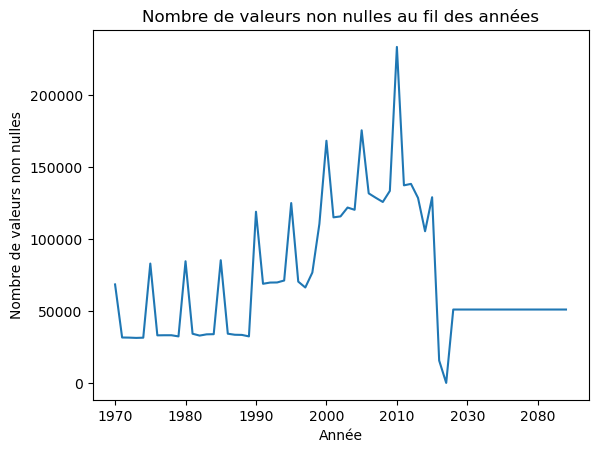

In [52]:
nb_info_colonnes = EdStatsData.apply(lambda x: x.count(), axis=0).drop(labels=["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis = 0)
nb_info_colonnes = pd.Series(nb_info_colonnes)
plot = nb_info_colonnes.plot(title='Nombre de valeurs non nulles au fil des années')
plot.set_xlabel("Année")
plot.set_ylabel("Nombre de valeurs non nulles")

In [53]:
display(nb_info_colonnes["2010"])
nb_info_colonnes["2020"]

233557

51128

- L'année 2010 possède le plus de valeurs (233557)
- Entre 2020 et 2100 on a exactement le même nombre de valeurs (51128)  
-> 2020 est l'année de commencement ou les valeurs sont des estimations futures
- Les valeurs réelles s'arretent a 2017 (pas de colonnes 2018 et 2019 dans le DataFrame)
- Comme on souhaite s'installer dans un pays, plus les valeurs sont récentes, plus l'analyse est pertinante
- On en déduit que la décénie 2010's (2010 -> 2017) est la tranche d'années la plus intéréssante pour la suite

In [54]:
df_2010 = EdStatsData[['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']]
df_2010_mean = df_2010.mean(axis=1)
EdStatsData2010s = EdStatsData[["Country Name", "Country Code", "Indicator Name", "Indicator Code"]]
EdStatsData2010s.loc[:, 'Annees 2010'] = df_2010_mean
EdStatsData2010s

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16496\1032276156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EdStatsData2010s.loc[:, 'Annees 2010'] = df_2010_mean


,Country Name,Country Code,Indicator Name,Indicator Code,Annees 2010
91625,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,49.032011
91626,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F,35.857401
91627,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",UIS.NERA.2.GPI,0.582715
91628,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, male (%)",UIS.NERA.2.M,61.497005
91629,Afghanistan,AFG,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,NaN
...,...,...,...,...,...
886925,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, male (number)",UIS.LP.AG15T24.M,183071.500000
886926,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, both sexes (%)",SE.ADT.1524.LT.ZS,90.679410
886927,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, female (%)",SE.ADT.1524.LT.FE.ZS,92.656455
886928,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, gender parity index (GPI)",SE.ADT.1524.LT.FM.ZS,1.046085


In [55]:
nb_info_colonnes = EdStatsData2010s.apply(lambda x: x.count(), axis=0).drop(
    labels=["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis = 0)
nb_info_colonnes

Annees 2010    304770
dtype: int64

Ce regroupement est pertinant car nous disposons maintenant de plus de données (304770) que le nombre maximum de données par pays (2010 -> 233557).

## Indicateurs avec le plus d'informations (fonction)

In [56]:
calculate_fill_rate(EdStatsData2010s)

,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
2369,SP.POP.GROW,Population growth (annual %),213,99.069767
2370,SP.POP.TOTL,"Population, total",213,99.069767
2025,SE.PRM.DURS,Theoretical duration of primary education (years),208,96.744186
2015,SE.PRM.AGES,Official entrance age to primary education (years),208,96.744186
2067,SE.SEC.AGES,Official entrance age to lower secondary education (years),205,95.348837
...,...,...,...,...
728,LO.EGRA.LSTN.0.AMH.2GRD,EGRA: Listening Comprehension - Share of students with a zero score (%). Amharic. 2nd Grade,1,0.465116
727,LO.EGRA.LSTN.0.AKU.2GRD,EGRA: Listening Comprehension - Share of students with a zero score (%). Akuapem. 2nd Grade,1,0.465116
726,LO.EGRA.LSTN.0.AFA.3GRD,EGRA: Listening Comprehension - Share of students with a zero score (%). Afan Oromo. 3rd Grade,1,0.465116
725,LO.EGRA.LSTN.0.AFA.2GRD,EGRA: Listening Comprehension - Share of students with a zero score (%). Afan Oromo. 2nd Grade,1,0.465116


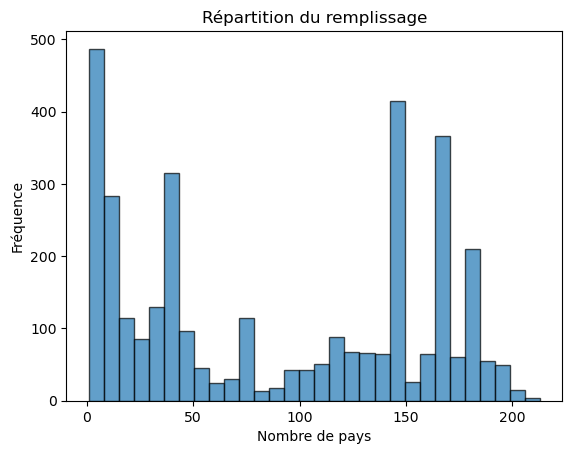

In [57]:
plt.hist(calculate_fill_rate(EdStatsData2010s)['NbDePays'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Nombre de pays')
plt.ylabel('Fréquence')
plt.title('Répartition du remplissage')
plt.show()


- On n'a plus que 3445 indicateurs (sur les 3665 totaux) -> 200 indicateurs n'ont aucune valeurs dans la décénie concernée
- 2 indicateurs (Population growth (annual%) et Population, total) one un taux de remplissage max de 213 sur les 215 pays proposés  
-> Regardons les 2 pays n'ayant pas les valeurs pour les indicateurs de Populations

In [58]:
# Récupération des lignes associées à l'indicateur 'SP.POP.GROW' et avec des NaN dans la colonne 'Annees 2010'
null_rows = EdStatsData2010s.loc[((EdStatsData2010s['Indicator Code'] == 'SP.POP.GROW') | (EdStatsData2010s['Indicator Code'] == 'SP.POP.TOTL')) & (EdStatsData2010s['Annees 2010'].isna())]

# Récupération des 'Country Name' uniques associés à ces lignes
unique_countries = null_rows['Country Name'].unique()

# Afficher les 'Country Name' uniques
print(unique_countries)


['British Virgin Islands' 'Nauru']


British Virgin Islands -> 30030 hab (estimation 2019)  
Nauru -> 9770 hab (estimation 2021)

-> Très petites zones, on peut les enlever de la liste

In [59]:
# Filtre logique pour sélectionner les lignes à supprimer
mask = (~EdStatsData2010s['Country Name'].isin(['British Virgin Islands', 'Nauru']))

# Suppression des lignes sélectionnées
EdStatsData2010s = EdStatsData2010s[mask]

## Indicateur Population 

- La population totale est un indicateur très important pour l'implantation dans un pays
- La croissance de la population est aussi important pour envisager un futur 

In [60]:
mask = EdStatsData2010s["Indicator Code"] == "SP.POP.GROW" 
PopGrowth = EdStatsData2010s[mask][["Country Name", "Annees 2010"]]
PopGrowth

,Country Name,Annees 2010
93932,Afghanistan,3.044466
97597,Albania,-0.253139
101262,Algeria,1.933563
104927,American Samoa,-0.160455
108592,Andorra,-1.269337
...,...,...
870912,Virgin Islands (U.S.),-0.511909
874577,West Bank and Gaza,2.950561
878242,"Yemen, Rep.",2.612001
881907,Zambia,2.991826


In [61]:
mask = EdStatsData2010s["Indicator Code"] == "SP.POP.TOTL" 
PopTot = EdStatsData2010s[mask][["Country Name", "Annees 2010"]]
PopTot

,Country Name,Annees 2010
94158,Afghanistan,3.172728e+07
97823,Albania,2.894231e+06
101488,Algeria,3.834750e+07
105153,American Samoa,5.543814e+04
108818,Andorra,8.084814e+04
...,...,...
871138,Virgin Islands (U.S.),1.046797e+05
874803,West Bank and Gaza,4.174707e+06
878468,"Yemen, Rep.",2.558457e+07
882133,Zambia,1.518298e+07


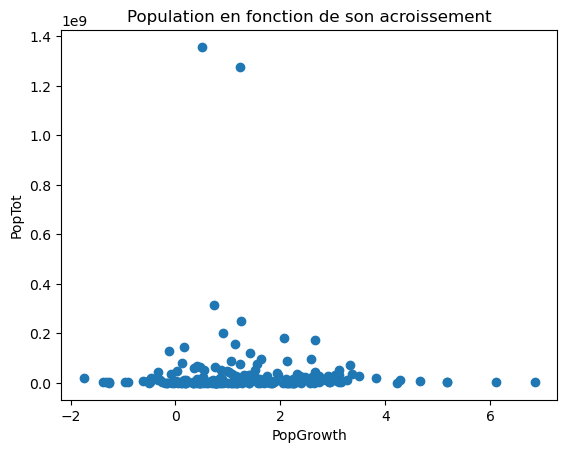

,Country Name,PopGrowth,PopTot
0,Afghanistan,3.044466,3.172728e+07
1,Albania,-0.253139,2.894231e+06
2,Algeria,1.933563,3.834750e+07
3,American Samoa,-0.160455,5.543814e+04
4,Andorra,-1.269337,8.084814e+04
...,...,...,...
208,Virgin Islands (U.S.),-0.511909,1.046797e+05
209,West Bank and Gaza,2.950561,4.174707e+06
210,"Yemen, Rep.",2.612001,2.558457e+07
211,Zambia,2.991826,1.518298e+07


In [62]:
# fusionner les deux dataframes sur la colonne "Country Name"
DfPop = pd.merge(PopGrowth, PopTot, on="Country Name")
DfPop = DfPop.rename(columns={"Annees 2010_x": "PopGrowth", "Annees 2010_y": "PopTot"})

# tracer un nuage de points
plt.scatter(DfPop["PopGrowth"], DfPop["PopTot"])

# ajouter des étiquettes aux axes
plt.xlabel("PopGrowth")
plt.ylabel("PopTot")
plt.title('Population en fonction de son acroissement')
          
# afficher le graphique
plt.show()
DfPop

- On peut ne prendre en compte que les pays ayant un PopGrowth > 0

In [63]:
DfPop = DfPop.loc[DfPop["PopGrowth"] > 0]
DfPop

,Country Name,PopGrowth,PopTot
0,Afghanistan,3.044466,3.172728e+07
2,Algeria,1.933563,3.834750e+07
5,Angola,3.501825,2.603935e+07
6,Antigua and Barbuda,1.084668,9.782029e+04
7,Argentina,1.029265,4.253773e+07
...,...,...,...
207,Vietnam,1.067748,8.978640e+07
209,West Bank and Gaza,2.950561,4.174707e+06
210,"Yemen, Rep.",2.612001,2.558457e+07
211,Zambia,2.991826,1.518298e+07


- On a désormais 188 pays en notre disposition  
-> Nous pouvons aussi ne tenir compte que des 2/3 des pays les plus peuplés.

In [64]:
deux_tiers = DfPop["PopTot"].quantile(1/3)
deux_tiers


2159126.0476190466

In [65]:
DfPop = DfPop.loc[DfPop["PopTot"] > deux_tiers]
DfPop

,Country Name,PopGrowth,PopTot
0,Afghanistan,3.044466,3.172728e+07
2,Algeria,1.933563,3.834750e+07
5,Angola,3.501825,2.603935e+07
7,Argentina,1.029265,4.253773e+07
8,Armenia,0.178074,2.896616e+06
...,...,...,...
207,Vietnam,1.067748,8.978640e+07
209,West Bank and Gaza,2.950561,4.174707e+06
210,"Yemen, Rep.",2.612001,2.558457e+07
211,Zambia,2.991826,1.518298e+07


  <b><center><span style="font-size: 25px;"><font color="#90EE90">En utilisant l'indicateur de Population, on se retrouve avec 125 pays à considérer </font></span></center></b> 


In [66]:
mask = EdStatsData2010s["Country Name"].isin(DfPop["Country Name"])
EdStatsData2010sPop = EdStatsData2010s[mask]
EdStatsData2010sPop

,Country Name,Country Code,Indicator Name,Indicator Code,Annees 2010
91625,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,49.032011
91626,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F,35.857401
91627,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",UIS.NERA.2.GPI,0.582715
91628,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, male (%)",UIS.NERA.2.M,61.497005
91629,Afghanistan,AFG,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,NaN
...,...,...,...,...,...
886925,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, male (number)",UIS.LP.AG15T24.M,183071.500000
886926,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, both sexes (%)",SE.ADT.1524.LT.ZS,90.679410
886927,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, female (%)",SE.ADT.1524.LT.FE.ZS,92.656455
886928,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, gender parity index (GPI)",SE.ADT.1524.LT.FM.ZS,1.046085


---

## A la recherche d'un nouvel indicateur

Pour aller plus vite on va supprimer certains termes qui nous sont inutiles
- female
- male 
- pre-primary
- primary
- lower secondary
- secondary (pas upper secondary par contre)


In [67]:
fill_rate = calculate_fill_rate(EdStatsData2010sPop)
fill_rate = fill_rate[~fill_rate['Indicator Name'].str.contains(
    r'lower secondary|female|male|pre-primary|primary', case=False)]
fill_rate = fill_rate[~((fill_rate['Indicator Name'].str.contains("secondary", case=False)) & ~(fill_rate['Indicator Name'].str.contains(
    "upper secondary", case=False)))]
fill_rate


,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
2073,SE.SEC.DURS.UP,Theoretical duration of upper secondary education (years),125,100.0
2370,SP.POP.TOTL,"Population, total",125,100.0
2290,SP.POP.1564.TO.ZS,"Population, ages 15-64 (% of total)",125,100.0
2184,SP.POP.0014.TO.ZS,"Population, ages 0-14 (% of total)",125,100.0
2183,SP.POP.0014.TO,"Population, ages 0-14, total",125,100.0
...,...,...,...,...
824,LO.EGRA.ORF.DAN.2GRD,EGRA: Oral Reading Fluency - Correct Words Read Per Minute (Mean). Dangme. 2nd Grade,1,0.8
826,LO.EGRA.ORF.ENG.3GRD,EGRA: Oral Reading Fluency - Correct Words Read Per Minute (Mean). English. 3rd Grade,1,0.8
827,LO.EGRA.ORF.ENG.6GRD,EGRA: Oral Reading Fluency - Correct Words Read Per Minute (Mean). English. 6th Grade,1,0.8
828,LO.EGRA.ORF.EWE.2GRD,EGRA: Oral Reading Fluency - Correct Words Read Per Minute (Mean). Ewe. 2nd Grade,1,0.8


In [68]:
# On enleve les indicateurs précédemment étudiés
mask = fill_rate["Taux de remplissage"] == 100
taux = fill_rate[mask]

exclude = ["SP.POP.GROW", "SP.POP.TOTL"]
taux = taux[~taux["Indicator Code"].isin(exclude)]

display(taux)
print(str(taux.shape[0]) + " indicateurs ont un taux de remplissage a 100%, on va considérer un EdStatsData avec uniquement ces indicateurs")


,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
2073,SE.SEC.DURS.UP,Theoretical duration of upper secondary education (years),125,100.0
2290,SP.POP.1564.TO.ZS,"Population, ages 15-64 (% of total)",125,100.0
2184,SP.POP.0014.TO.ZS,"Population, ages 0-14 (% of total)",125,100.0
2183,SP.POP.0014.TO,"Population, ages 0-14, total",125,100.0
2289,SP.POP.1564.TO,"Population, ages 15-64, total",125,100.0
3326,UIS.THAGE.3.A.GPV,Official entrance age to upper secondary education (years),125,100.0


6 indicateurs ont un taux de remplissage a 100%, on va considérer un EdStatsData avec uniquement ces indicateurs


L'indicateur SE.SEC.DURS.UP (Theoretical duration of upper secondary education (years)) est intéréssant car il nous permet de voir combien d'années un éleve reste lycéen dans un pays.  
On pourrait aller plus loin en combinant cette duration la duration de l'enseignement supérieur

In [69]:
mask= fill_rate["Indicator Name"].str.contains("duration")
Duration = fill_rate[mask]
Duration

,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
2073,SE.SEC.DURS.UP,Theoretical duration of upper secondary education (years),125,100.0


Malheureusement, on n'a pas de durée théorique pour le supérieur, on ne peut pas conclure grand chose avec simplement l'indicateur "upper secondary education" (car même si on a beaucoup d'années au lycée cela peut peut etre se compenser par moins d'années en université, il aurait fallu avoir l'addition des deux pour avoir une conclusion définitive)

-> On va etre obligé de regarder des indicateurs avec un taux de remplissage < 100%

In [70]:
mask = fill_rate["Taux de remplissage"] < 100
taux = fill_rate[mask]
max_fill_rate = taux["Taux de remplissage"].max()
mask = fill_rate["Taux de remplissage"] == max_fill_rate
taux = fill_rate[mask]

exclude = ["SP.POP.GROW", "SP.POP.TOTL", "SE.SEC.DURS.UP"]
taux = taux[~taux["Indicator Code"].isin(exclude)]

display(taux)
print(str(taux.shape[0]) + " indicateurs ont un taux de remplissage égal au maximum mais en dessous de 100%.")

,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
2344,SP.POP.AG17.TO.UN,"Population, age 17, total",124,99.2
2350,SP.POP.AG19.TO.UN,"Population, age 19, total",124,99.2
2353,SP.POP.AG20.TO.UN,"Population, age 20, total",124,99.2
2347,SP.POP.AG18.TO.UN,"Population, age 18, total",124,99.2
2341,SP.POP.AG16.TO.UN,"Population, age 16, total",124,99.2
...,...,...,...,...
2235,SP.POP.1016.TO.UN,"Population, ages 10-16, total",124,99.2
2241,SP.POP.1018.TO.UN,"Population, ages 10-18, total",124,99.2
2244,SP.POP.1115.TO.UN,"Population, ages 11-15, total",124,99.2
2247,SP.POP.1116.TO.UN,"Population, ages 11-16, total",124,99.2


68 indicateurs ont un taux de remplissage égal au maximum mais en dessous de 100%.


On va créer une heatmap pour identifier les indicateurs corrélés entre elles

In [71]:
mask = EdStatsData2010sPop["Indicator Code"].isin(taux["Indicator Code"])
df_filtered = EdStatsData2010sPop[mask]

# Création d'un dataframe pivot (Pays en lignes et Indicateurs en colonnes)
pivot_table = df_filtered.pivot(index='Country Name', columns='Indicator Code', values='Annees 2010')
pivot_table

Indicator Code,IT.NET.USER.P2,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,NY.GNP.MKTP.CD,SH.DYN.MORT,SL.TLF.TOTL.IN,SL.UEM.TOTL.ZS,SP.POP.0305.TO.UN,SP.POP.0406.TO.UN,SP.POP.0509.TO.UN,...,SP.POP.AG17.TO.UN,SP.POP.AG18.TO.UN,SP.POP.AG19.TO.UN,SP.POP.AG20.TO.UN,SP.POP.AG21.TO.UN,SP.POP.AG22.TO.UN,SP.POP.AG23.TO.UN,SP.POP.AG24.TO.UN,SP.POP.AG25.TO.UN,SP.SEC.UTOT.IN
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,6.601467,1.902638e+10,600.145379,1.923199e+10,79.771429,9.101783e+06,8.357143,3.279678e+06,3.152279e+06,4.908183e+06,...,725380.6,699724.6,673189.8,647178.0,621438.8,596597.6,573119.6,550735.6,528705.4,2.035841e+06
Algeria,25.535075,1.883963e+11,4925.084760,1.844602e+11,26.014286,1.164807e+07,10.585714,2.084456e+06,2.050245e+06,3.281546e+06,...,656372.8,672386.8,688118.4,703946.6,719714.6,731856.4,738597.6,741010.0,742212.0,1.992388e+06
Angola,8.128571,1.074245e+11,4134.962750,9.910492e+10,98.700000,1.069504e+07,6.185714,1.983129e+06,1.904232e+06,2.943236e+06,...,428840.2,417139.8,405217.6,393686.8,382576.4,370579.8,357158.2,342879.8,328852.0,1.556589e+06
Argentina,59.227690,5.297579e+11,12443.170313,5.171621e+11,12.742857,1.909205e+07,7.500000,2.047842e+06,2.038905e+06,3.378117e+06,...,693496.6,693510.6,691643.2,689868.2,688234.2,684743.4,678743.0,671282.8,663411.2,2.069631e+06
Armenia,44.589312,1.055405e+10,3643.013183,1.100146e+10,15.600000,1.401987e+06,17.771429,1.063803e+05,1.042377e+05,1.681562e+05,...,46201.4,49041.6,51857.8,54550.2,57170.8,58981.2,59611.4,59352.8,58949.6,1.120241e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,38.860000,1.661764e+11,1844.583633,1.588944e+11,22.528571,5.370206e+07,2.085714,4.904693e+06,4.895251e+06,8.054400e+06,...,1717112.4,1756189.2,1793597.2,1829508.2,1866138.2,1882074.2,1867378.8,1831801.8,1795601.8,4.776448e+06
West Bank and Gaza,48.678940,1.170280e+10,2793.289949,1.286568e+10,21.200000,1.076937e+06,24.400000,4.313380e+05,4.248078e+05,6.860850e+05,...,103779.4,100162.8,96858.2,93487.4,90142.2,86790.8,83386.2,79981.2,76702.4,2.048703e+05
"Yemen, Rep.",19.416588,3.538881e+10,1385.564040,3.372115e+10,55.471429,5.712306e+06,17.228571,2.435602e+06,2.367493e+06,3.738330e+06,...,604573.6,591145.4,575889.4,560745.4,545500.0,529046.4,511084.8,492056.4,472816.2,1.802144e+06


In [72]:
# On vérifie quels pays possèdent des Nan
df = pivot_table
mask = df.isna().any(axis=1)
result = df[mask]

result

Indicator Code,IT.NET.USER.P2,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,NY.GNP.MKTP.CD,SH.DYN.MORT,SL.TLF.TOTL.IN,SL.UEM.TOTL.ZS,SP.POP.0305.TO.UN,SP.POP.0406.TO.UN,SP.POP.0509.TO.UN,...,SP.POP.AG17.TO.UN,SP.POP.AG18.TO.UN,SP.POP.AG19.TO.UN,SP.POP.AG20.TO.UN,SP.POP.AG21.TO.UN,SP.POP.AG22.TO.UN,SP.POP.AG23.TO.UN,SP.POP.AG24.TO.UN,SP.POP.AG25.TO.UN,SP.SEC.UTOT.IN
Country Name,,,,,,,,,,,,,,,,,,,,,
"Hong Kong SAR, China",77.63071,2.767507e+11,38433.985802,2.829249e+11,NaN,3.842278e+06,3.485714,181886.333333,185403.000000,3.208100e+05,...,84107.0,85732.6,86917.6,88217.4,89483.8,91086.8,93257.8,95790.0,98218.2,2.587336e+05
"Korea, Dem. People’s Rep.",0.00000,NaN,NaN,NaN,24.342857,1.576429e+07,4.300000,882115.666667,886324.500000,1.539163e+06,...,415469.0,413544.6,406613.4,399304.0,390326.0,383573.8,381335.2,381578.2,380973.4,1.195296e+06
Singapore,76.27775,2.865219e+11,53303.572545,2.779612e+11,2.757143,3.052990e+06,2.557143,111807.166667,114691.166667,2.073227e+05,...,69970.6,70481.6,69762.4,69013.8,68113.0,66809.8,65136.2,63237.2,61239.6,NaN
South Sudan,NaN,1.418322e+10,1349.479580,1.096782e+10,104.900000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.007774e+06


4 pays possèdent des Nan, on va les supprimer (uniquement pour le pivot_table)  
-> Pas de moyenne ni d'interpolations, cela risquerait de fausser les résultats  
-> 126 pays -> 122 -> Toujours suffisament de données, donc la suppression est pertinante

In [73]:
pivot_table = pivot_table.dropna()
pivot_table

Indicator Code,IT.NET.USER.P2,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,NY.GNP.MKTP.CD,SH.DYN.MORT,SL.TLF.TOTL.IN,SL.UEM.TOTL.ZS,SP.POP.0305.TO.UN,SP.POP.0406.TO.UN,SP.POP.0509.TO.UN,...,SP.POP.AG17.TO.UN,SP.POP.AG18.TO.UN,SP.POP.AG19.TO.UN,SP.POP.AG20.TO.UN,SP.POP.AG21.TO.UN,SP.POP.AG22.TO.UN,SP.POP.AG23.TO.UN,SP.POP.AG24.TO.UN,SP.POP.AG25.TO.UN,SP.SEC.UTOT.IN
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,6.601467,1.902638e+10,600.145379,1.923199e+10,79.771429,9.101783e+06,8.357143,3.279678e+06,3.152279e+06,4.908183e+06,...,725380.6,699724.6,673189.8,647178.0,621438.8,596597.6,573119.6,550735.6,528705.4,2.035841e+06
Algeria,25.535075,1.883963e+11,4925.084760,1.844602e+11,26.014286,1.164807e+07,10.585714,2.084456e+06,2.050245e+06,3.281546e+06,...,656372.8,672386.8,688118.4,703946.6,719714.6,731856.4,738597.6,741010.0,742212.0,1.992388e+06
Angola,8.128571,1.074245e+11,4134.962750,9.910492e+10,98.700000,1.069504e+07,6.185714,1.983129e+06,1.904232e+06,2.943236e+06,...,428840.2,417139.8,405217.6,393686.8,382576.4,370579.8,357158.2,342879.8,328852.0,1.556589e+06
Argentina,59.227690,5.297579e+11,12443.170313,5.171621e+11,12.742857,1.909205e+07,7.500000,2.047842e+06,2.038905e+06,3.378117e+06,...,693496.6,693510.6,691643.2,689868.2,688234.2,684743.4,678743.0,671282.8,663411.2,2.069631e+06
Armenia,44.589312,1.055405e+10,3643.013183,1.100146e+10,15.600000,1.401987e+06,17.771429,1.063803e+05,1.042377e+05,1.681562e+05,...,46201.4,49041.6,51857.8,54550.2,57170.8,58981.2,59611.4,59352.8,58949.6,1.120241e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,38.860000,1.661764e+11,1844.583633,1.588944e+11,22.528571,5.370206e+07,2.085714,4.904693e+06,4.895251e+06,8.054400e+06,...,1717112.4,1756189.2,1793597.2,1829508.2,1866138.2,1882074.2,1867378.8,1831801.8,1795601.8,4.776448e+06
West Bank and Gaza,48.678940,1.170280e+10,2793.289949,1.286568e+10,21.200000,1.076937e+06,24.400000,4.313380e+05,4.248078e+05,6.860850e+05,...,103779.4,100162.8,96858.2,93487.4,90142.2,86790.8,83386.2,79981.2,76702.4,2.048703e+05
"Yemen, Rep.",19.416588,3.538881e+10,1385.564040,3.372115e+10,55.471429,5.712306e+06,17.228571,2.435602e+06,2.367493e+06,3.738330e+06,...,604573.6,591145.4,575889.4,560745.4,545500.0,529046.4,511084.8,492056.4,472816.2,1.802144e+06


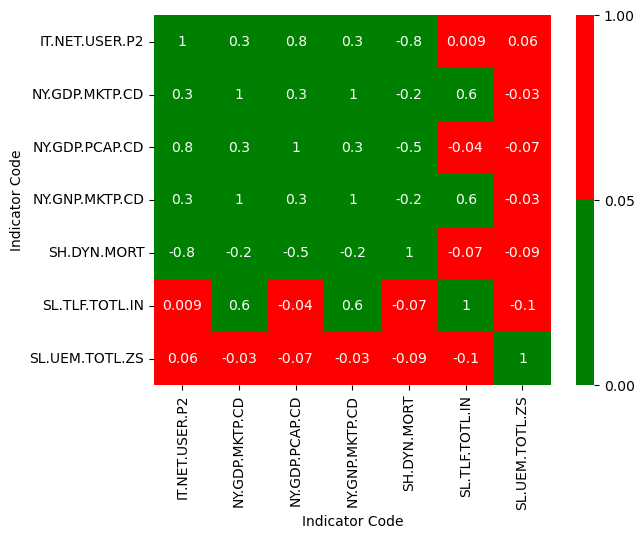

In [74]:
# La heatmap va etre illisible si on récupere tout, on va prendre que les X premiers indicateurs juste pour voir
X=7
pivot_tableX = pivot_table.iloc[:, :X]

# Calculer les coefficients de corrélation et les p-values pour chaque couple de colonnes
corr_matrix = pd.DataFrame(np.zeros((X,X)), columns=pivot_tableX.columns, index=pivot_tableX.columns)
p_matrix = pd.DataFrame(np.zeros((X,X)), columns=pivot_tableX.columns, index=pivot_tableX.columns)

for i in range(X):
    for j in range(X):
        corr, p_value = stats.pearsonr(pivot_table.iloc[:,i], pivot_tableX.iloc[:,j])
        corr_matrix.iloc[i,j] = corr
        p_matrix.iloc[i,j] = p_value

# Définir les couleurs vert et rouge pour les p-values <= 0.05 et > 0.05 respectivement
cmap = mpl.colors.ListedColormap(['green', 'red'])
bounds = [0, 0.05, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Créer une heatmap à partir de la matrice de p-value
sns.heatmap(p_matrix, annot=corr_matrix, fmt='.1g', annot_kws={'size': 10}, cmap=cmap, norm=norm, vmin=0, vmax=1)

# Afficher la heatmap
plt.show()

Si nous avons un coefficient de corrélation de Pearson compris entre -1 et -0.7 ou entre 0.7 et 1 et une p-value inférieure à 0.05, nous pouvons considérer que les deux indicateurs sont fortement corrélés et qu'il y a donc une redondance.

In [75]:
corr_matrix, p_matrix = calculate_correlation_matrix(pivot_table)

In [76]:
Correlation = find_correlated_indicators(pivot_table, corr_matrix, p_matrix)
Correlation

,Indicateur A,Indicateur B,Correlation,P-Value
0,IT.NET.USER.P2,IT.NET.USER.P2,1.000000,0.000000e+00
1,IT.NET.USER.P2,NY.GDP.PCAP.CD,0.826720,1.656653e-31
2,IT.NET.USER.P2,SH.DYN.MORT,-0.773227,2.702515e-25
3,NY.GDP.MKTP.CD,NY.GDP.MKTP.CD,1.000000,0.000000e+00
4,NY.GDP.MKTP.CD,NY.GNP.MKTP.CD,0.999900,4.665800e-222
...,...,...,...,...
1957,SP.POP.AG24.TO.UN,SP.POP.AG25.TO.UN,0.999965,5.413468e-249
1958,SP.POP.AG24.TO.UN,SP.SEC.UTOT.IN,0.958919,5.857878e-67
1959,SP.POP.AG25.TO.UN,SP.POP.AG25.TO.UN,1.000000,0.000000e+00
1960,SP.POP.AG25.TO.UN,SP.SEC.UTOT.IN,0.957217,6.235723e-66


In [77]:
indicateurs = find_least_correlated_indicator(Correlation, taux)
indicateurs

,Indicateur A,Indicateur B,Correlation,P-Value
5,NY.GDP.PCAP.CD,NY.GDP.PCAP.CD,1.0,0.0
6,NY.GNP.MKTP.CD,NY.GNP.MKTP.CD,1.0,0.0
7,SH.DYN.MORT,SH.DYN.MORT,1.0,0.0
70,SL.UEM.TOTL.ZS,SL.UEM.TOTL.ZS,1.0,0.0
1961,SP.SEC.UTOT.IN,SP.SEC.UTOT.IN,1.0,0.0


,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
2391,SP.SEC.UTOT.IN,"Population of the official age for upper secondary education, both sexes (number)",124,99.2
1442,NY.GDP.PCAP.CD,GDP per capita (current US$),124,99.2
1446,NY.GNP.MKTP.CD,GNI (current US$),124,99.2
2163,SH.DYN.MORT,"Mortality rate, under-5 (per 1,000)",124,99.2
2180,SL.UEM.TOTL.ZS,"Unemployment, total (% of total labor force)",124,99.2


Le GDP et le GNI sont les indicateurs les plus intéréssants dans cette liste

Le Produit intérieur brut (PIB) par habitant (GDP per capita) et le Revenu national brut (RNB) par habitant (GNI per capita) sont tous deux des indicateurs importants de la richesse des citoyens d'un pays. Cependant, ils peuvent donner des images différentes de la richesse d'une nation et de sa distribution.

Le GDP per capita mesure la production économique totale d'un pays divisée par sa population. C'est un indicateur largement utilisé pour mesurer la richesse et le développement économique d'un pays. Cependant, le GDP per capita ne tient pas compte des transferts de revenus entre les pays et ne reflète pas toujours la réalité de la vie quotidienne des citoyens. Par exemple, un pays peut avoir un GDP per capita élevé, mais une large partie de sa population peut être très pauvre.

Le GNI per capita, également connu sous le nom de revenu national net, est similaire au GDP per capita, mais il tient compte des transferts de revenus entre les pays. Il mesure la richesse totale produite par les citoyens d'un pays, y compris les revenus gagnés à l'étranger. C'est un indicateur plus fiable pour mesurer la richesse réelle des citoyens d'un pays et leur niveau de vie.

En conclusion, le GNI per capita peut être considéré comme un indicateur plus précis de la richesse des citoyens d'un pays, car il tient compte des transferts de revenus entre les pays et reflète mieux la réalité de la vie quotidienne des citoyens.



## Indicateur Revenu National Brut (RNB ou GNI)

In [78]:
mask = EdStatsData2010sPop["Indicator Code"] == "NY.GNP.PCAP.CD" 
RNB = EdStatsData2010sPop[mask][["Country Name", "Annees 2010"]]
RNB

,Country Name,Annees 2010
92876,Afghanistan,598.571429
100206,Algeria,4878.571429
111201,Angola,3822.857143
118531,Argentina,11571.428571
122196,Armenia,3850.000000
...,...,...
866191,Vietnam,1705.714286
873521,West Bank and Gaza,2967.142857
877186,"Yemen, Rep.",1215.714286
880851,Zambia,1542.857143


In [79]:
# Spécifier les classes pour la répartition des pays
# Déterminer la longueur de chaque bin
min_value = round(RNB['Annees 2010'].min())
max_value = round(RNB['Annees 2010'].max())
bin_width = round((max_value - min_value) / 10)

# Déterminer les bornes de chaque bin
bins = np.arange(start=min_value, stop=max_value + bin_width, step=bin_width)

# Créer une copie de l'objet RNB
RNB_copy = RNB.copy()

# Répartir les pays dans les différentes classes
RNB_copy['Revenu National Brut'] = pd.cut(RNB_copy['Annees 2010'], bins)

# Compter le nombre de valeurs dans chaque classe et afficher le résultat.
bin_counts = RNB_copy['Revenu National Brut'].value_counts()

# Transforme le tout en dataframe
bin_counts_df = bin_counts.to_frame()
bin_counts_df.reset_index(inplace=True)
bin_counts_df.columns = ['Revenu National Brut', 'Nombre']

# Tri du dataframe par ordre croissant des classes de revenu
bin_counts_df = bin_counts_df.sort_values(by='Revenu National Brut', ignore_index=True)

bin_counts_df


,Revenu National Brut,Nombre
0,"(261, 9709]",84
1,"(9709, 19157]",13
2,"(19157, 28605]",2
3,"(28605, 38053]",4
4,"(38053, 47501]",8
5,"(47501, 56949]",6
6,"(56949, 66397]",3
7,"(66397, 75845]",1
8,"(75845, 85293]",1
9,"(85293, 94741]",1


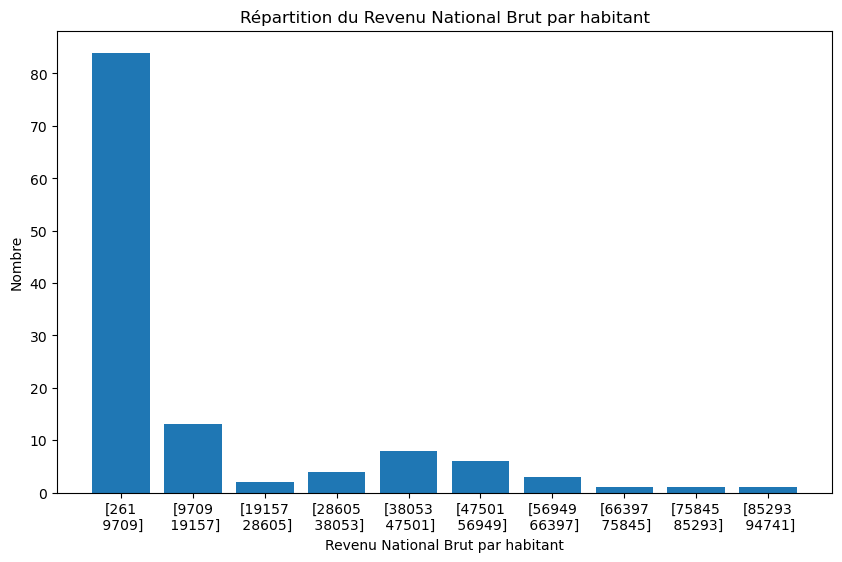

In [80]:
bin_counts_df['Revenu National Brut'] = bin_counts_df['Revenu National Brut'].astype(str)

# Boucle sur les étiquettes de barre pour les formater
new_labels = []
for bin_string in bin_counts_df['Revenu National Brut']:
    lower, upper = bin_string.split(',')
    bin_label = lower + '\n' + upper
    bin_label = bin_label.replace('(', '[')
    new_labels.append(bin_label)


# Création d'un graphique en bar
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(new_labels, bin_counts_df['Nombre'])
ax.set_xlabel('Revenu National Brut par habitant')
ax.set_ylabel('Nombre')
ax.set_title('Répartition du Revenu National Brut par habitant')
plt.show()

Beaucoup de pays ont un RNB très bas (en dessous de 9709 dollars par habitant)  
-> On peut prendre les pays ayant au moins 50% du max.

In [81]:
result = RNB[RNB['Annees 2010'] >= max_value/2]
print(max_value/2)
result

47369.5


,Country Name,Annees 2010
129526,Australia,57400.000000
133191,Austria,49258.571429
221151,Canada,48230.000000
287121,Denmark,61268.571429
334766,Finland,48242.857143
602311,Netherlands,51354.285714
627966,Norway,94738.571429
671946,Qatar,75375.000000
715926,Singapore,51298.571429
778231,Sweden,57442.857143


In [82]:
mask = EdStatsData2010sPop["Country Name"].isin(result["Country Name"])
EdStatsData2010sPop = EdStatsData2010sPop[mask]
EdStatsData2010sPop

,Country Name,Country Code,Indicator Name,Indicator Code,Annees 2010
128275,Australia,AUS,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,86.046183
128276,Australia,AUS,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F,87.719564
128277,Australia,AUS,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",UIS.NERA.2.GPI,1.038297
128278,Australia,AUS,"Adjusted net enrolment rate, lower secondary, male (%)",UIS.NERA.2.M,84.484358
128279,Australia,AUS,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,97.379276
...,...,...,...,...,...
850275,United States,USA,"Youth illiterate population, 15-24 years, male (number)",UIS.LP.AG15T24.M,NaN
850276,United States,USA,"Youth literacy rate, population 15-24 years, both sexes (%)",SE.ADT.1524.LT.ZS,NaN
850277,United States,USA,"Youth literacy rate, population 15-24 years, female (%)",SE.ADT.1524.LT.FE.ZS,NaN
850278,United States,USA,"Youth literacy rate, population 15-24 years, gender parity index (GPI)",SE.ADT.1524.LT.FM.ZS,NaN


On obtient plus que 12 pays à considérer

## A la recherche d'un nouvel indicateur

In [83]:
fill_rate = calculate_fill_rate(EdStatsData2010sPop)
fill_rate = fill_rate[~fill_rate['Indicator Name'].str.contains(
    r'lower secondary|female|male|pre-primary|primary', case=False)]
fill_rate = fill_rate[~((fill_rate['Indicator Name'].str.contains("secondary", case=False)) & ~(fill_rate['Indicator Name'].str.contains(
    "upper secondary", case=False)))]
fill_rate

,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
815,PRJ.ATT.2529.NED.MF,Wittgenstein Projection: Percentage of the population age 25-29 by highest level of educational attainment. No Education. Total,12,100.000000
827,PRJ.ATT.25UP.3.MF,Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Upper Secondary. Total,12,100.000000
833,PRJ.ATT.25UP.NED.MF,Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. No Education. Total,12,100.000000
791,PRJ.ATT.2064.3.MF,Wittgenstein Projection: Percentage of the population age 20-64 by highest level of educational attainment. Upper Secondary. Total,12,100.000000
809,PRJ.ATT.2529.3.MF,Wittgenstein Projection: Percentage of the population age 25-29 by highest level of educational attainment. Upper Secondary. Total,12,100.000000
...,...,...,...,...
1060,SABER.WORK.GOAL1,SABER: (Workforce Development) Policy Goal 1: Strategic Framework,1,8.333333
1021,SABER.EMIS.GOAL1.LVL2,SABER: (Education Management Information Systems) Policy Goal 1 Lever 2: Organizational Structure,1,8.333333
1022,SABER.EMIS.GOAL1.LVL3,SABER: (Education Management Information Systems) Policy Goal 1 Lever 3: Human Resources,1,8.333333
1023,SABER.EMIS.GOAL1.LVL4,SABER: (Education Management Information Systems) Policy Goal 1 Lever 4: Infrastructural capacity,1,8.333333


In [84]:
mask = fill_rate["Taux de remplissage"] == 100
taux = fill_rate[mask]

# On enleve les indicateurs précédemment étudiés
exclude = ["SP.POP.GROW", "SP.POP.TOTL", "NY.GNP.PCAP.CD", "SE.SEC.DURS.UP"]
taux = taux[~taux["Indicator Code"].isin(exclude)]

taux

,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
815,PRJ.ATT.2529.NED.MF,Wittgenstein Projection: Percentage of the population age 25-29 by highest level of educational attainment. No Education. Total,12,100.0
827,PRJ.ATT.25UP.3.MF,Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Upper Secondary. Total,12,100.0
833,PRJ.ATT.25UP.NED.MF,Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. No Education. Total,12,100.0
791,PRJ.ATT.2064.3.MF,Wittgenstein Projection: Percentage of the population age 20-64 by highest level of educational attainment. Upper Secondary. Total,12,100.0
809,PRJ.ATT.2529.3.MF,Wittgenstein Projection: Percentage of the population age 25-29 by highest level of educational attainment. Upper Secondary. Total,12,100.0
...,...,...,...,...
327,BAR.TER.ICMP.7074.ZS,Barro-Lee: Percentage of population age 70-74 with tertiary schooling. Total (Incomplete and Completed Tertiary),12,100.0
332,BAR.TER.SCHL.15UP,"Barro-Lee: Average years of tertiary schooling, age 15+, total",12,100.0
2115,UIS.THAGE.3.A.GPV,Official entrance age to upper secondary education (years),12,100.0
330,BAR.TER.SCHL.1519,"Barro-Lee: Average years of tertiary schooling, age 15-19, total",12,100.0


In [85]:
mask = EdStatsData2010sPop["Indicator Code"].isin(taux["Indicator Code"])
df_filtered = EdStatsData2010sPop[mask]

# Création d'un dataframe pivot (Pays en lignes et Indicateurs en colonnes)
pivot_table = df_filtered.pivot(index='Country Name', columns='Indicator Code', values='Annees 2010')
pivot_table

Indicator Code,BAR.NOED.1519.ZS,BAR.NOED.15UP.ZS,BAR.NOED.2024.ZS,BAR.NOED.2529.ZS,BAR.NOED.25UP.ZS,BAR.NOED.3034.ZS,BAR.NOED.3539.ZS,BAR.NOED.4044.ZS,BAR.NOED.4549.ZS,BAR.NOED.5054.ZS,...,UIS.EA.3.AG25T99,UIS.EA.3T6.AG25T99,UIS.EA.3T6.AG25T99.GPI,UIS.EA.5T8.AG25T99,UIS.EA.5T8.AG25T99.GPI,UIS.EA.6.AG25T99,UIS.MENF.56,UIS.MS.56.T,UIS.OE.56.40510,UIS.THAGE.3.A.GPV
Country Name,,,,,,,,,,,,,,,,,,,,,
Australia,0.11,0.72,0.11,0.23,0.78,0.32,0.40,0.52,0.69,0.81,...,30.995646,73.695700,0.96,38.239527,1.200,31.547090,247278.500000,259866.400000,11042.50,16.000000
Austria,0.10,1.29,0.11,0.15,1.48,5.82,5.39,2.99,0.72,0.08,...,49.926434,77.398001,0.80,20.836373,0.720,1.628060,52635.312500,66650.044531,14386.00,14.000000
Canada,0.10,0.67,2.20,0.55,0.58,0.12,0.21,0.21,0.33,0.33,...,23.108670,82.748993,1.00,47.674568,1.100,47.674570,74935.333333,128418.750000,45859.50,14.571429
Denmark,0.00,2.64,2.64,8.36,2.89,5.44,3.08,3.08,2.43,2.43,...,42.457702,76.258722,1.02,32.761767,1.180,28.787098,16936.000000,24033.000000,5620.00,16.000000
Finland,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,38.566133,71.996838,1.00,33.115947,1.200,21.637513,9462.000000,18411.200000,7862.75,16.000000
Netherlands,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,36.080922,68.133816,0.90,29.638278,0.820,24.012062,34798.000000,48196.000000,13398.00,15.000000
Norway,3.05,5.74,6.77,13.65,5.85,13.89,7.94,7.94,4.53,4.53,...,38.824110,76.474497,1.00,33.913746,1.100,25.395490,-2700.250000,13858.600000,17713.50,16.000000
Qatar,1.16,3.59,2.44,2.92,3.90,2.92,3.56,3.56,4.39,4.39,...,18.651636,41.844377,1.34,18.480034,1.800,19.205902,3240.250000,7469.400000,3577.00,15.000000
Singapore,1.76,15.27,0.90,0.82,16.39,1.36,2.85,5.83,9.73,14.93,...,18.974546,68.173210,0.90,40.216068,0.840,25.797510,27976.250000,49608.750000,21632.50,14.000000


In [86]:
corr_matrix, p_matrix = calculate_correlation_matrix(pivot_table)

In [87]:
Correlation = find_correlated_indicators(pivot_table, corr_matrix, p_matrix)
Correlation

,Indicateur A,Indicateur B,Correlation,P-Value
0,BAR.NOED.1519.ZS,BAR.NOED.1519.ZS,1.000000,0.000000e+00
1,BAR.NOED.15UP.ZS,BAR.NOED.15UP.ZS,1.000000,0.000000e+00
2,BAR.NOED.15UP.ZS,BAR.NOED.25UP.ZS,0.999028,6.836973e-15
3,BAR.NOED.15UP.ZS,BAR.NOED.4044.ZS,0.741800,5.746455e-03
4,BAR.NOED.15UP.ZS,BAR.NOED.4549.ZS,0.972657,1.149632e-07
...,...,...,...,...
10051,UIS.MENF.56,UIS.OE.56.40510,0.736268,6.324022e-03
10052,UIS.MS.56.T,UIS.MS.56.T,1.000000,0.000000e+00
10053,UIS.MS.56.T,UIS.OE.56.40510,0.777150,2.936392e-03
10054,UIS.OE.56.40510,UIS.OE.56.40510,1.000000,0.000000e+00


On va considérer l'indicateur le moins corrélé et voir si il pourrait nous intéresser

In [88]:
indicateurs = find_least_correlated_indicator(Correlation, taux)
indicateurs

,Indicateur A,Indicateur B,Correlation,P-Value
0,BAR.NOED.1519.ZS,BAR.NOED.1519.ZS,1.0,0.000000e+00
6554,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD,1.0,4.250614e-78
7090,PRJ.MYS.1519.MF,PRJ.MYS.1519.MF,1.0,1.328317e-79
7753,SE.COM.DURS,SE.COM.DURS,1.0,0.000000e+00
7760,SE.XPD.TOTL.GB.ZS,SE.XPD.TOTL.GB.ZS,1.0,0.000000e+00
7761,SE.XPD.TOTL.GD.ZS,SE.XPD.TOTL.GD.ZS,1.0,0.000000e+00
7762,SH.DYN.MORT,SH.DYN.MORT,1.0,0.000000e+00
7898,SP.POP.0014.TO.ZS,SP.POP.0014.TO.ZS,1.0,0.000000e+00
10036,UIS.CEAGE.1,UIS.CEAGE.1,1.0,1.328317e-79
10041,UIS.EA.3.AG25T99,UIS.EA.3.AG25T99,1.0,0.000000e+00


,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
914,PRJ.MYS.1519.MF,Wittgenstein Projection: Mean years of schooling. Age 15-19. Total,12,100.0
688,NY.GDP.PCAP.KD,GDP per capita (constant 2005 US$),12,100.0
1483,UIS.CEAGE.1,Official entrance age to compulsory education (years),12,100.0
1634,UIS.EA.6.AG25T99,UIS: Percentage of population age 25+ with a completed bachelor's or equivalent degree (ISCED 6). Total,12,100.0
1632,UIS.EA.5T8.AG25T99.GPI,UIS: Percentage of population age 25+ with at least a completed short-cycle tertiary degree (ISCED 5 or higher). Gender Parity Index,12,100.0
1613,UIS.EA.3.AG25T99,UIS: Percentage of population age 25+ with completed upper secondary education. Total,12,100.0
1,BAR.NOED.1519.ZS,Barro-Lee: Percentage of population age 15-19 with no education,12,100.0
1079,SE.COM.DURS,Duration of compulsory education (years),12,100.0
1240,SE.XPD.TOTL.GB.ZS,Expenditure on education as % of total government expenditure (%),12,100.0
1241,SE.XPD.TOTL.GD.ZS,Government expenditure on education as % of GDP (%),12,100.0


L'indicateur BAR.NOED.1519.ZS (Percentage of population age 15-19 with no education) est intéréssant mais il le serait mieux si on avait cet indicateur pour la tranche 15-24 ans (début lycée -> Fin Master)  
-> On va analyser de plus près les indicateurs possedant le code "BAR.NOED"

In [89]:
IndicateurBAR = taux[taux["Indicator Code"].str.contains("BAR.NOED")]
IndicateurBAR = IndicateurBAR[~IndicateurBAR["Indicator Name"].str.contains("female")]
IndicateurBAR

,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
1,BAR.NOED.1519.ZS,Barro-Lee: Percentage of population age 15-19 with no education,12,100.0
17,BAR.NOED.4549.ZS,Barro-Lee: Percentage of population age 45-49 with no education,12,100.0
15,BAR.NOED.4044.ZS,Barro-Lee: Percentage of population age 40-44 with no education,12,100.0
13,BAR.NOED.3539.ZS,Barro-Lee: Percentage of population age 35-39 with no education,12,100.0
11,BAR.NOED.3034.ZS,Barro-Lee: Percentage of population age 30-34 with no education,12,100.0
9,BAR.NOED.25UP.ZS,Barro-Lee: Percentage of population age 25+ with no education,12,100.0
7,BAR.NOED.2529.ZS,Barro-Lee: Percentage of population age 25-29 with no education,12,100.0
5,BAR.NOED.2024.ZS,Barro-Lee: Percentage of population age 20-24 with no education,12,100.0
3,BAR.NOED.15UP.ZS,Barro-Lee: Percentage of population age 15+ with no education,12,100.0
19,BAR.NOED.5054.ZS,Barro-Lee: Percentage of population age 50-54 with no education,12,100.0


On a (15-19) et (20-24), ces 2 indicateurs vont nous permettre d'avoir une situation précise sur le taux d'éducation sur la tranche d'age souhaitée

## Indicateur taux d'éducation (15-24)

On peut considérer qu'un taux d'éducation inférieur à 90% serait éliminatoire

In [90]:
mask = EdStatsData2010sPop["Indicator Code"] == "BAR.NOED.1519.ZS" 
Educ1519 = EdStatsData2010sPop[mask][["Country Name", "Annees 2010"]]
display(Educ1519)

max_index = Educ1519['Annees 2010'].idxmax()
max_country = Educ1519.loc[max_index, 'Country Name']
max = Educ1519['Annees 2010'].max()

print(f'Le pays le taux d\'éducation le moins élevé pour les 15-19 ans est: {max_country}. avec {100-max} %')

,Country Name,Annees 2010
128656,Australia,0.11
132321,Austria,0.10
220281,Canada,0.10
286251,Denmark,0.00
333896,Finland,0.00
601441,Netherlands,0.00
627096,Norway,3.05
671076,Qatar,1.16
715056,Singapore,1.76
777361,Sweden,5.76


Le pays le taux d'éducation le moins élevé pour les 15-19 ans est: Sweden. avec 94.24 %


##### Aucun pays n'a un taux inférieur a 90% pour cette tranche d'age

In [91]:
mask = EdStatsData2010sPop["Indicator Code"] == "BAR.NOED.2024.ZS" 
Educ2024 = EdStatsData2010sPop[mask][["Country Name", "Annees 2010"]]
display(Educ2024)

max_index = Educ2024['Annees 2010'].idxmax()
max_country = Educ2024.loc[max_index, 'Country Name']
max = Educ2024['Annees 2010'].max()

print(f'Le pays le taux d\'éducation le moins élevé pour les 20-24 ans est: {max_country}. avec {100-max} %')

,Country Name,Annees 2010
128663,Australia,0.11
132328,Austria,0.11
220288,Canada,2.20
286258,Denmark,2.64
333903,Finland,0.00
601448,Netherlands,0.00
627103,Norway,6.77
671083,Qatar,2.44
715063,Singapore,0.90
777368,Sweden,3.66


Le pays le taux d'éducation le moins élevé pour les 20-24 ans est: Norway. avec 93.23 %


##### Aucun pays n'a un taux inférieur a 90% pour cette tranche d'age

Cet indicateur ne nous a pas permis d'affiner nos résultats.

## A la recherche d'un nouvel indicateur

In [92]:
fill_rate = calculate_fill_rate(EdStatsData2010sPop)
fill_rate = fill_rate[~fill_rate['Indicator Name'].str.contains(
    r'lower secondary|female|male|pre-primary|primary', case=False)]
fill_rate = fill_rate[~((fill_rate['Indicator Name'].str.contains("secondary", case=False)) & ~(fill_rate['Indicator Name'].str.contains(
    "upper secondary", case=False)))]
fill_rate

,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
815,PRJ.ATT.2529.NED.MF,Wittgenstein Projection: Percentage of the population age 25-29 by highest level of educational attainment. No Education. Total,12,100.000000
827,PRJ.ATT.25UP.3.MF,Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Upper Secondary. Total,12,100.000000
833,PRJ.ATT.25UP.NED.MF,Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. No Education. Total,12,100.000000
791,PRJ.ATT.2064.3.MF,Wittgenstein Projection: Percentage of the population age 20-64 by highest level of educational attainment. Upper Secondary. Total,12,100.000000
809,PRJ.ATT.2529.3.MF,Wittgenstein Projection: Percentage of the population age 25-29 by highest level of educational attainment. Upper Secondary. Total,12,100.000000
...,...,...,...,...
1060,SABER.WORK.GOAL1,SABER: (Workforce Development) Policy Goal 1: Strategic Framework,1,8.333333
1021,SABER.EMIS.GOAL1.LVL2,SABER: (Education Management Information Systems) Policy Goal 1 Lever 2: Organizational Structure,1,8.333333
1022,SABER.EMIS.GOAL1.LVL3,SABER: (Education Management Information Systems) Policy Goal 1 Lever 3: Human Resources,1,8.333333
1023,SABER.EMIS.GOAL1.LVL4,SABER: (Education Management Information Systems) Policy Goal 1 Lever 4: Infrastructural capacity,1,8.333333


In [93]:
mask = fill_rate["Taux de remplissage"] == 100
taux = fill_rate[mask]

# On enleve les indicateurs précédemment étudiés
exclude = ["SP.POP.GROW", "SP.POP.TOTL", "NY.GNP.PCAP.CD", "SE.SEC.DURS.UP", "BAR.NOED"]
taux = taux[~taux["Indicator Code"].str.startswith(tuple(exclude))]

taux

,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
815,PRJ.ATT.2529.NED.MF,Wittgenstein Projection: Percentage of the population age 25-29 by highest level of educational attainment. No Education. Total,12,100.0
827,PRJ.ATT.25UP.3.MF,Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Upper Secondary. Total,12,100.0
833,PRJ.ATT.25UP.NED.MF,Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. No Education. Total,12,100.0
791,PRJ.ATT.2064.3.MF,Wittgenstein Projection: Percentage of the population age 20-64 by highest level of educational attainment. Upper Secondary. Total,12,100.0
809,PRJ.ATT.2529.3.MF,Wittgenstein Projection: Percentage of the population age 25-29 by highest level of educational attainment. Upper Secondary. Total,12,100.0
...,...,...,...,...
327,BAR.TER.ICMP.7074.ZS,Barro-Lee: Percentage of population age 70-74 with tertiary schooling. Total (Incomplete and Completed Tertiary),12,100.0
332,BAR.TER.SCHL.15UP,"Barro-Lee: Average years of tertiary schooling, age 15+, total",12,100.0
2115,UIS.THAGE.3.A.GPV,Official entrance age to upper secondary education (years),12,100.0
330,BAR.TER.SCHL.1519,"Barro-Lee: Average years of tertiary schooling, age 15-19, total",12,100.0


In [94]:
mask = EdStatsData2010sPop["Indicator Code"].isin(taux["Indicator Code"])
df_filtered = EdStatsData2010sPop[mask]

# Création d'un dataframe pivot (Pays en lignes et Indicateurs en colonnes)
pivot_table = df_filtered.pivot(index='Country Name', columns='Indicator Code', values='Annees 2010')
pivot_table

Indicator Code,BAR.POP.1519,BAR.POP.15UP,BAR.POP.2024,BAR.POP.2529,BAR.POP.25UP,BAR.POP.3034,BAR.POP.3539,BAR.POP.4044,BAR.POP.4549,BAR.POP.5054,...,UIS.EA.3.AG25T99,UIS.EA.3T6.AG25T99,UIS.EA.3T6.AG25T99.GPI,UIS.EA.5T8.AG25T99,UIS.EA.5T8.AG25T99.GPI,UIS.EA.6.AG25T99,UIS.MENF.56,UIS.MS.56.T,UIS.OE.56.40510,UIS.THAGE.3.A.GPV
Country Name,,,,,,,,,,,,,,,,,,,,,
Australia,1421.0,17323.0,1478.0,1500.0,14424.0,1448.0,1506.0,1535.0,1524.0,1471.0,...,30.995646,73.695700,0.96,38.239527,1.200,31.547090,247278.500000,259866.400000,11042.50,16.000000
Austria,482.0,7090.0,489.0,516.0,6119.0,498.0,585.0,711.0,714.0,607.0,...,49.926434,77.398001,0.80,20.836373,0.720,1.628060,52635.312500,66650.044531,14386.00,14.000000
Canada,2230.0,28292.0,2269.0,2308.0,23793.0,2305.0,2310.0,2422.0,2768.0,2625.0,...,23.108670,82.748993,1.00,47.674568,1.100,47.674570,74935.333333,128418.750000,45859.50,14.571429
Denmark,357.0,4515.0,316.0,297.0,3842.0,345.0,392.0,411.0,406.0,368.0,...,42.457702,76.258722,1.02,32.761767,1.180,28.787098,16936.000000,24033.000000,5620.00,16.000000
Finland,335.0,4451.0,324.0,337.0,3792.0,333.0,309.0,353.0,378.0,378.0,...,38.566133,71.996838,1.00,33.115947,1.200,21.637513,9462.000000,18411.200000,7862.75,16.000000
Netherlands,1021.0,13722.0,990.0,948.0,11711.0,983.0,1177.0,1347.0,1332.0,1213.0,...,36.080922,68.133816,0.90,29.638278,0.820,24.012062,34798.000000,48196.000000,13398.00,15.000000
Norway,319.0,3859.0,298.0,278.0,3242.0,289.0,339.0,358.0,332.0,316.0,...,38.824110,76.474497,1.00,33.913746,1.100,25.395490,-2700.250000,13858.600000,17713.50,16.000000
Qatar,52.0,694.0,60.0,90.0,582.0,118.0,113.0,85.0,67.0,53.0,...,18.651636,41.844377,1.34,18.480034,1.800,19.205902,3240.250000,7469.400000,3577.00,15.000000
Singapore,356.0,3872.0,300.0,276.0,3216.0,273.0,328.0,398.0,439.0,425.0,...,18.974546,68.173210,0.90,40.216068,0.840,25.797510,27976.250000,49608.750000,21632.50,14.000000


In [95]:
corr_matrix, p_matrix = calculate_correlation_matrix(pivot_table)

In [96]:
Correlation = find_correlated_indicators(pivot_table, corr_matrix, p_matrix)
Correlation

,Indicateur A,Indicateur B,Correlation,P-Value
0,BAR.POP.1519,BAR.POP.1519,1.000000,0.000000e+00
1,BAR.POP.1519,BAR.POP.15UP,0.999896,9.675377e-20
2,BAR.POP.1519,BAR.POP.2024,0.999989,1.528472e-24
3,BAR.POP.1519,BAR.POP.2529,0.999939,6.453069e-21
4,BAR.POP.1519,BAR.POP.25UP,0.999849,6.085180e-19
...,...,...,...,...
9794,UIS.MENF.56,UIS.OE.56.40510,0.736268,6.324022e-03
9795,UIS.MS.56.T,UIS.MS.56.T,1.000000,0.000000e+00
9796,UIS.MS.56.T,UIS.OE.56.40510,0.777150,2.936392e-03
9797,UIS.OE.56.40510,UIS.OE.56.40510,1.000000,0.000000e+00


In [97]:
indicateurs = find_least_correlated_indicator(Correlation, taux)
indicateurs

,Indicateur A,Indicateur B,Correlation,P-Value
6297,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD,1.0,4.250614e-78
6833,PRJ.MYS.1519.MF,PRJ.MYS.1519.MF,1.0,1.328317e-79
7496,SE.COM.DURS,SE.COM.DURS,1.0,0.000000e+00
7503,SE.XPD.TOTL.GB.ZS,SE.XPD.TOTL.GB.ZS,1.0,0.000000e+00
7504,SE.XPD.TOTL.GD.ZS,SE.XPD.TOTL.GD.ZS,1.0,0.000000e+00
7505,SH.DYN.MORT,SH.DYN.MORT,1.0,0.000000e+00
7641,SP.POP.0014.TO.ZS,SP.POP.0014.TO.ZS,1.0,0.000000e+00
9779,UIS.CEAGE.1,UIS.CEAGE.1,1.0,1.328317e-79
9784,UIS.EA.3.AG25T99,UIS.EA.3.AG25T99,1.0,0.000000e+00
9785,UIS.EA.3T6.AG25T99,UIS.EA.3T6.AG25T99,1.0,0.000000e+00


,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
914,PRJ.MYS.1519.MF,Wittgenstein Projection: Mean years of schooling. Age 15-19. Total,12,100.0
688,NY.GDP.PCAP.KD,GDP per capita (constant 2005 US$),12,100.0
1483,UIS.CEAGE.1,Official entrance age to compulsory education (years),12,100.0
1634,UIS.EA.6.AG25T99,UIS: Percentage of population age 25+ with a completed bachelor's or equivalent degree (ISCED 6). Total,12,100.0
1632,UIS.EA.5T8.AG25T99.GPI,UIS: Percentage of population age 25+ with at least a completed short-cycle tertiary degree (ISCED 5 or higher). Gender Parity Index,12,100.0
1613,UIS.EA.3.AG25T99,UIS: Percentage of population age 25+ with completed upper secondary education. Total,12,100.0
1079,SE.COM.DURS,Duration of compulsory education (years),12,100.0
1240,SE.XPD.TOTL.GB.ZS,Expenditure on education as % of total government expenditure (%),12,100.0
1241,SE.XPD.TOTL.GD.ZS,Government expenditure on education as % of GDP (%),12,100.0
1243,SH.DYN.MORT,"Mortality rate, under-5 (per 1,000)",12,100.0


L'indicateur : UIS.EA.6.AG25T99	UIS: Percentage of population age 25+ with a completed bachelor's or equivalent degree (ISCED 6). Total  
-> Intéréssant car nous permet de savoir le % de clients potentiels suceptible d'avoir des cours complets (lycée + au moins 3 ans dans le supérieur)

## Indicateur Pourcentage Licence minimum

In [98]:
mask = EdStatsData2010sPop["Indicator Code"] == "UIS.EA.6.AG25T99" 
MinBachelor = EdStatsData2010sPop[mask][["Country Name", "Annees 2010"]]
MinBachelor

,Country Name,Annees 2010
131475,Australia,31.547090
135140,Austria,1.628060
223100,Canada,47.674570
289070,Denmark,28.787098
336715,Finland,21.637513
604260,Netherlands,24.012062
629915,Norway,25.395490
673895,Qatar,19.205902
717875,Singapore,25.797510
780180,Sweden,21.907546


In [99]:
# Spécifier les classes pour la répartition des pays
# Déterminer la longueur de chaque bin
min_value = 0
max_value = round(MinBachelor['Annees 2010'].max())
bin_width = round((max_value - min_value) / 10)

# Déterminer les bornes de chaque bin
bins = np.arange(start=min_value, stop=max_value + bin_width, step=bin_width)

# Créer une copie de l'objet RNB
MinBachelor_copy = MinBachelor.copy()

# Répartir les pays dans les différentes classes
MinBachelor_copy['MinBachelor'] = pd.cut(MinBachelor_copy['Annees 2010'], bins)

# Compter le nombre de valeurs dans chaque classe et afficher le résultat.
bin_counts = MinBachelor_copy['MinBachelor'].value_counts()

# Transforme le tout en dataframe
bin_counts_df = bin_counts.to_frame()
bin_counts_df.reset_index(inplace=True)
bin_counts_df.columns = ['MinBachelor', 'Nombre']

# Tri du dataframe par ordre croissant des classes de revenu
bin_counts_df = bin_counts_df.sort_values(by='MinBachelor', ignore_index=True)

bin_counts_df

,MinBachelor,Nombre
0,"(0, 5]",1
1,"(5, 10]",0
2,"(10, 15]",0
3,"(15, 20]",1
4,"(20, 25]",3
5,"(25, 30]",4
6,"(30, 35]",2
7,"(35, 40]",0
8,"(40, 45]",0
9,"(45, 50]",1


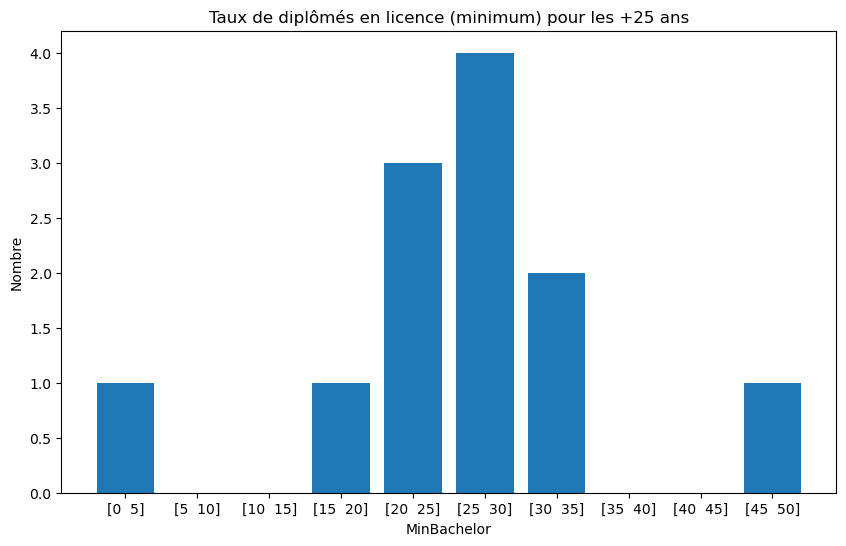

In [100]:
bin_counts_df['MinBachelor'] = bin_counts_df['MinBachelor'].astype(str)

# Boucle sur les étiquettes de barre pour les formater
new_labels = []
for bin_string in bin_counts_df['MinBachelor']:
    lower, upper = bin_string.split(',')
    bin_label = lower + ' ' + upper
    bin_label = bin_label.replace('(', '[')
    new_labels.append(bin_label)


# Création d'un graphique en bar
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(new_labels, bin_counts_df['Nombre'])
ax.set_xlabel('MinBachelor')
ax.set_ylabel('Nombre')
ax.set_title('Taux de diplômés en licence (minimum) pour les +25 ans')
plt.show()

D'après la courbe, prendre 25% minimum serait intéréssant à envisager

In [101]:
result = MinBachelor[MinBachelor['Annees 2010'] >= 25]
result

,Country Name,Annees 2010
131475,Australia,31.547090
223100,Canada,47.674570
289070,Denmark,28.787098
629915,Norway,25.395490
717875,Singapore,25.797510
783845,Switzerland,29.621270
849815,United States,32.006050


Nous n'avons plus que 7 pays au final

In [102]:
mask = EdStatsData2010sPop["Country Name"].isin(result["Country Name"])
EdStatsData2010sPop = EdStatsData2010sPop[mask]
EdStatsData2010sPop

,Country Name,Country Code,Indicator Name,Indicator Code,Annees 2010
128275,Australia,AUS,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,86.046183
128276,Australia,AUS,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F,87.719564
128277,Australia,AUS,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",UIS.NERA.2.GPI,1.038297
128278,Australia,AUS,"Adjusted net enrolment rate, lower secondary, male (%)",UIS.NERA.2.M,84.484358
128279,Australia,AUS,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,97.379276
...,...,...,...,...,...
850275,United States,USA,"Youth illiterate population, 15-24 years, male (number)",UIS.LP.AG15T24.M,NaN
850276,United States,USA,"Youth literacy rate, population 15-24 years, both sexes (%)",SE.ADT.1524.LT.ZS,NaN
850277,United States,USA,"Youth literacy rate, population 15-24 years, female (%)",SE.ADT.1524.LT.FE.ZS,NaN
850278,United States,USA,"Youth literacy rate, population 15-24 years, gender parity index (GPI)",SE.ADT.1524.LT.FM.ZS,NaN


## A la recherche d'un nouvel indicateur

Comme on propose des cours en ligne, il serait aussi intéréssant de considérer la proportion d'utilisateurs internet

In [103]:
fill_rate = calculate_fill_rate(EdStatsData2010sPop)
fill_rate = fill_rate[~fill_rate['Indicator Name'].str.contains(
    r'lower secondary|female|male|pre-primary|primary', case=False)]
fill_rate = fill_rate[~((fill_rate['Indicator Name'].str.contains("secondary", case=False)) & ~(fill_rate['Indicator Name'].str.contains(
    "upper secondary", case=False)))]
fill_rate

fill_rate[fill_rate["Indicator Name"].str.contains("internet", case=False)]

,Indicator Code,Indicator Name,NbDePays,Taux de remplissage
360,IT.NET.USER.P2,Internet users (per 100 people),7,100.0


## Indicateur Utilisateurs d'internet

In [104]:
mask = EdStatsData2010sPop["Indicator Code"] == "IT.NET.USER.P2" 
InternetUsers = EdStatsData2010sPop[mask][["Country Name", "Annees 2010"]]
InternetUsers

,Country Name,Annees 2010
129650,Australia,82.105767
221275,Canada,85.361429
287245,Denmark,93.529716
628090,Norway,95.284552
716050,Singapore,76.277750
782020,Switzerland,86.416807
847990,United States,73.035771


In [105]:
# Spécifier les classes pour la répartition des pays
bins = [0, 10, 20, 40, 50, 60, 70, 80, 90, 100]
InternetUsers['Utilisateurs internet'] = pd.cut(InternetUsers['Annees 2010'], bins)


# Compte le nombre de valeurs dans chaque classe et affiche le résultat.
bin_counts = InternetUsers['Utilisateurs internet'].value_counts()

# Transforme le tout en dataframe
bin_counts_df = bin_counts.to_frame()
bin_counts_df.reset_index(inplace=True)
bin_counts_df.columns = ['Utilisateurs internet', 'Nombre']
bin_counts_df = bin_counts_df.sort_values('Utilisateurs internet')
bin_counts_df

,Utilisateurs internet,Nombre
3,"(0, 10]",0
4,"(10, 20]",0
5,"(20, 40]",0
6,"(40, 50]",0
7,"(50, 60]",0
8,"(60, 70]",0
1,"(70, 80]",2
0,"(80, 90]",3
2,"(90, 100]",2


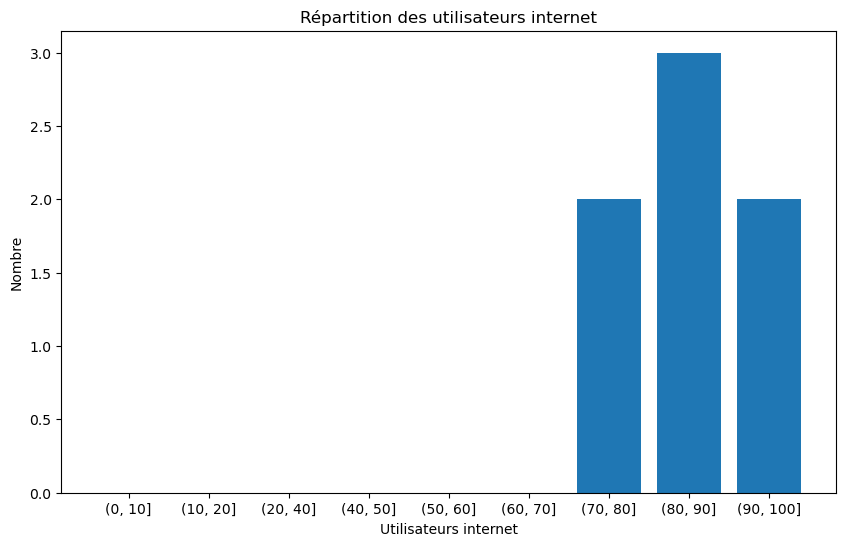

In [106]:
# Convertit le tableau "Utilisateurs Internet" en strings
bin_counts_df['Utilisateurs internet'] = bin_counts_df['Utilisateurs internet'].astype(str)

# Création d'un graphique en bar
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(bin_counts_df['Utilisateurs internet'], bin_counts_df['Nombre'])
ax.set_xlabel('Utilisateurs internet')
ax.set_ylabel('Nombre')
ax.set_title('Répartition des utilisateurs internet')
plt.show()

Pour que l'implantation soit réussie, il est essentiel d'avoir un nombre important d'utilisateurs d'Internet, un taux d'au moins 70% semble être une valeur raisonnable.

In [107]:
mask = EdStatsData2010sPop[(EdStatsData2010sPop["Annees 2010"] > 70) & (
    (EdStatsData2010sPop["Indicator Code"]=="IT.NET.USER.P2"))]

mask2 = EdStatsData2010sPop["Country Code"].isin(mask["Country Code"])
EdStatsData2010sPopInt = EdStatsData2010sPop[mask2]
EdStatsData2010sPopInt

,Country Name,Country Code,Indicator Name,Indicator Code,Annees 2010
128275,Australia,AUS,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,86.046183
128276,Australia,AUS,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F,87.719564
128277,Australia,AUS,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",UIS.NERA.2.GPI,1.038297
128278,Australia,AUS,"Adjusted net enrolment rate, lower secondary, male (%)",UIS.NERA.2.M,84.484358
128279,Australia,AUS,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,97.379276
...,...,...,...,...,...
850275,United States,USA,"Youth illiterate population, 15-24 years, male (number)",UIS.LP.AG15T24.M,NaN
850276,United States,USA,"Youth literacy rate, population 15-24 years, both sexes (%)",SE.ADT.1524.LT.ZS,NaN
850277,United States,USA,"Youth literacy rate, population 15-24 years, female (%)",SE.ADT.1524.LT.FE.ZS,NaN
850278,United States,USA,"Youth literacy rate, population 15-24 years, gender parity index (GPI)",SE.ADT.1524.LT.FM.ZS,NaN


In [108]:
country_names = EdStatsData2010sPopInt["Country Name"].unique()
print(country_names)
display("Nous avons maintenant un total de " + str(country_names.shape[0]) + 
        " pays candidats")

['Australia' 'Canada' 'Denmark' 'Norway' 'Singapore' 'Switzerland'
 'United States']


'Nous avons maintenant un total de 7 pays candidats'

# En résumé

  <b><center><span style="font-size: 25px;">Traitement </span></center></b> 
- **EdStatsCountry** -> Informations générales sur les pays  
241 zones, 0 doublons
- **EdStatsCountrySeries** -> Donne les sources des données de EdStatsCountry  
211 zones, 0 doublons
- **EdStatsData** -> Tableau d'indicateurs pour chaque pays  
242 zones, 3665 indicateurs, 0 doublons  
- **EdStatsFootNote** -> Donne les précisions à laquel on a obtenus ces indicateurs  
239 zones, 2183 indicateurs, 0 doublons
- **EdStatsSeries** -> Donne les définitions, sources des indicateurs et dans quel groupe il appartient (Topic)  
3665 indicateurs, 0 doublons

Conclusion : On est parti sur un ensemble à 215 pays + 3665 indicateurs


  <b><center><span style="font-size: 25px;">Analyse </span></center></b> 
- Année 2010 avec le plus d'informations (233557)
- Regroupement (2010 -> 2017) pour avoir le max d'infos possibles (304770)
- 2 indicateurs <font color="#90EE90">(SP.POP.GROW = Population growth)</font> et <font color="#90EE90">(SP.POP.TOTL = Population, total )</font> présents dans 213 sur les 215 pays  
    -> Les 2 pays (British Virgin Islands et Nauru sont peu peuplés -> On peut les supprimer)  
    -> **(215 pays -> 213 pays)**
- Population growth > 0 et Population, total > 2/3 Pays -> **(215 Pays -> 126 Pays)**
- Maintenant on a 6 indicateurs avec un taux de remplissage a 100% (pour 126 pays)
- <font color="red">SE.SEC.DURS.UP (Durée théorique années études lycée)</font>  -> Pas assez pertinant (les moyennes des durées lycée + université aurait été mieux)
- On regarde les indicateurs avec un taux de remplissage < 100%
- On supprime dans le pivot_table les 3 pays (Hong Kong, Corée du Nord et Singapore) qui possèdent des NaN pour pouvoir faire nos tableaux de corrélation 

-  Méthode qui va nous servir tout au long de l'analyse
    - On utilise une heatmap pour regarder les corrélations entre elles
    - Coefficient de Pearson = [-1:-0.7] OU [0.7:1] / p-value < 0.05
    - On regarde les indicateurs ayant le moins de corrélation
    
1) <font color="red">NY.GDP.PCAP.CD (GDP per capita (current US)</font> ou <font color="#90EE90">NY.GNP.PCAP.CD (GNI per capita, Atlas method (current US$))</font>  
    -> <font color="#90EE90">NY.GNP.PCAP.CD (GNI ou RNB)</font> plus pertinant
    -> Pays possédant au moins 50% du RNB max -> **(126 pays -> 12 pays)**
    
2) <font color="#90EE90"> BAR.NOED.1519.ZS (Barro-Lee: Percentage of population age 15-19 with no education) </font>   
    -> On récupere<font color="#90EE90"> BAR.NOED.1519.ZS + BAR.NOED.2024.ZS </font> (Pour avoir la tranche d'age 15 ans -> 24 ans)  
    ->  <font color="#90EE90">(BAR.NOED.1519.ZS, BAR.NOED.2024.ZS)</font>  < 10 -> Aucun changement à ce stade  **(12 Pays -> 12 Pays)**
    
3) <font color="#90EE90"> UIS.EA.6.AG25T99 : Percentage of population age 25+ with a completed bachelor's or equivalent degree (ISCED 6). Total</font>   
    -> Intéréssant car donne le % de clients potentiels lycée + Licence minimum  
   <font color="#90EE90"> UIS.EA.6.AG25T99</font>  >= 25% -> **(12 pays -> 7 pays**
    
4) <font color="#90EE90">IT.NET.USER.P2 (Internet users (per 100 people)) </font>  
    -> <font color="#90EE90">IT.NET.USER.P2</font> > 70 % -> **(7 Pays -> 7 Pays)**
    
    
Conclusion : Les pays à considérer sont les suivants :
    -> Australie
    -> Canada
    -> Danemark
    -> Norvège 
    -> Singapore
    -> Suisse 
    -> Etats Unis
    



# Score attractivité

In [109]:
# On récupere Nauru et le British Virgin Islands
df_2010 = EdStatsData[['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']]
df_2010_mean = df_2010.mean(axis=1)
EdStatsData2010s = EdStatsData[["Country Name", "Country Code", "Indicator Name", "Indicator Code"]]
EdStatsData2010s.loc[:, 'Annees 2010'] = df_2010_mean

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16496\3520657412.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EdStatsData2010s.loc[:, 'Annees 2010'] = df_2010_mean


In [110]:
mask = (EdStatsData2010s["Indicator Code"] == "SP.POP.GROW") | (EdStatsData2010s["Indicator Code"] == "SP.POP.TOTL") | (
    EdStatsData2010s["Indicator Code"] == "NY.GNP.PCAP.CD") | (EdStatsData2010s["Indicator Code"] == "BAR.NOED.1519.ZS") |(
    EdStatsData2010s["Indicator Code"] == "BAR.NOED.2024.ZS") | (EdStatsData2010s["Indicator Code"] == "UIS.EA.6.AG25T99") |(
    EdStatsData2010s["Indicator Code"] == "IT.NET.USER.P2")

EdStatsDataFinal = EdStatsData2010s[mask]
EdStatsDataFinal 

EdStatsDataFinal = EdStatsDataFinal[EdStatsDataFinal['Country Name'].isin(country_names)]

In [111]:
# Création d'un dataframe pivot (Pays en lignes et Indicateurs en colonnes)
pivot_table = EdStatsDataFinal.pivot(index='Country Name', columns='Indicator Code', values='Annees 2010')

pivot_table_final = pivot_table

In [112]:
X = country_names.shape[0]

columns = ["BAR.NOED.1519.ZS", "BAR.NOED.2024.ZS"]

for col in columns:
    quantiles = pivot_table_final[col].quantile([(i+1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] < q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0
            
columns = ["NY.GNP.PCAP.CD", "SP.POP.GROW","SP.POP.TOTL", "IT.NET.USER.P2","UIS.EA.6.AG25T99"]
for col in columns:
    quantiles = pivot_table_final[col].quantile([(X-i-1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] > q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0

pivot_table_final = pivot_table_final.astype(int)
pivot_table_final = pivot_table_final.add(1)
pivot_table_final['Total'] = pivot_table_final.sum(axis=1)
pivot_table_final['Rank'] = pivot_table_final['Total'].rank(ascending=False).astype(int)
pivot_table_final = pivot_table_final.sort_values(by='Total', ascending=False)

pivot_table_final

Indicator Code,BAR.NOED.1519.ZS,BAR.NOED.2024.ZS,IT.NET.USER.P2,NY.GNP.PCAP.CD,SP.POP.GROW,SP.POP.TOTL,UIS.EA.6.AG25T99,Total,Rank
Country Name,,,,,,,,,
Australia,5,6,3,4,6,5,5,34,1
Canada,6,3,4,1,3,6,7,30,2
Switzerland,1,5,5,6,4,4,4,29,3
United States,4,6,1,3,2,7,6,29,3
Denmark,7,2,6,5,1,3,3,27,5
Norway,2,1,7,7,5,1,1,24,6
Singapore,3,4,2,2,7,2,2,22,7


In [113]:
index_number = pivot_table_final.index.get_loc("Switzerland")
index_number

2

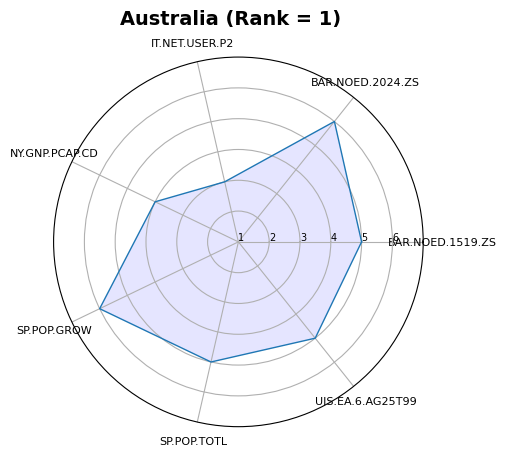

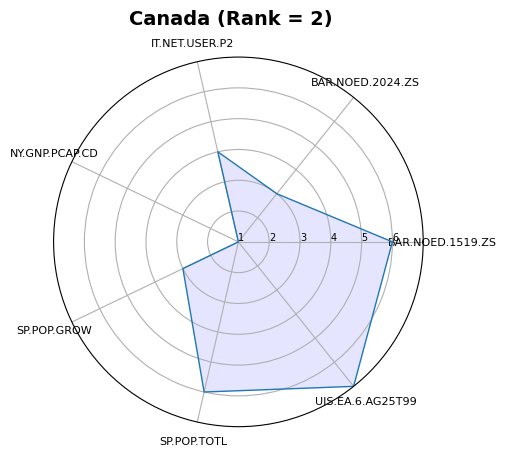

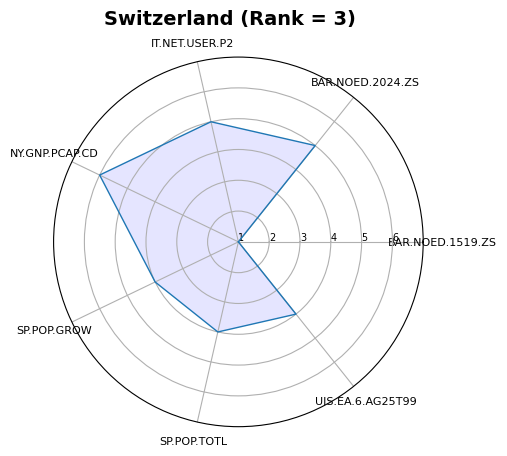

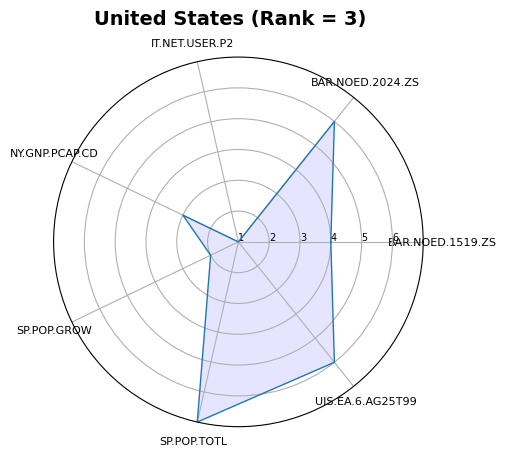

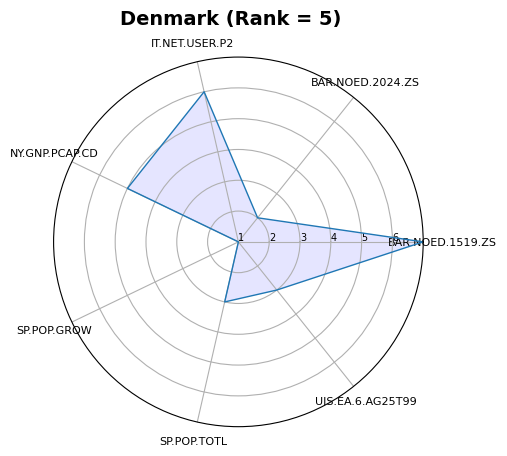

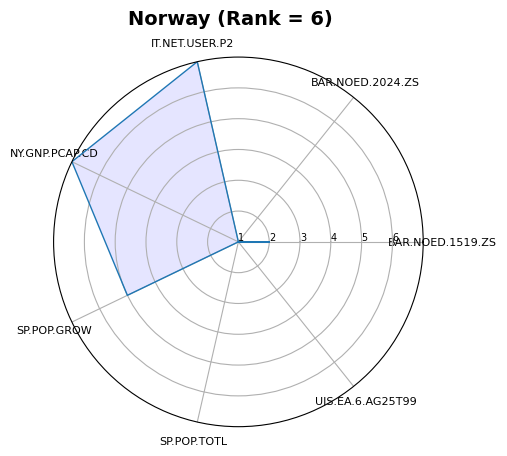

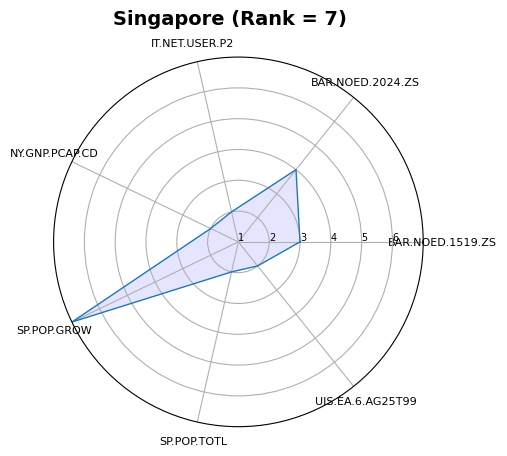

In [114]:
categories = pivot_table_final.columns[:].tolist()
categories = categories[:-2]
N = len(categories)

for Y in range(len(pivot_table_final)):
    values = pivot_table_final.loc[pivot_table_final.index[Y], categories].values.flatten().tolist()
    values += values[:1]
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)

    plt.xticks(angles[:-1], categories, size=8)

    ax.set_rlabel_position(0)
    plt.yticks(list(range(X)), [str(i) for i in range(X)], size=7)
    plt.ylim(1, X)

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)

    plt.suptitle(f"{pivot_table_final.index[Y]} (Rank = {pivot_table_final.loc[pivot_table_final.index[Y], 'Rank']})", fontsize=14, fontweight='bold', ha='center')
    plt.show()

# Evolution potentiel

In [115]:
mask = (EdStatsData["Indicator Code"] == "SP.POP.GROW") | (EdStatsData["Indicator Code"] == "SP.POP.TOTL") | (
    EdStatsData["Indicator Code"] == "NY.GNP.PCAP.CD") | (EdStatsData["Indicator Code"] == "BAR.NOED.1519.ZS") |(
    EdStatsData["Indicator Code"] == "BAR.NOED.2024.ZS") | (EdStatsData["Indicator Code"] == "UIS.EA.6.AG25T99") |(
    EdStatsData["Indicator Code"] == "IT.NET.USER.P2")

EdStatsDataFinal = EdStatsData[mask]
EdStatsDataFinal 

EdStatsDataFinal = EdStatsDataFinal[EdStatsDataFinal['Country Name'].isin(country_names)]
EdStatsDataFinal

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
128656,Australia,AUS,Barro-Lee: Percentage of population age 15-19 with no education,BAR.NOED.1519.ZS,3.000000e-01,NaN,NaN,NaN,NaN,2.090000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128663,Australia,AUS,Barro-Lee: Percentage of population age 20-24 with no education,BAR.NOED.2024.ZS,3.000000e-01,NaN,NaN,NaN,NaN,4.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129526,Australia,AUS,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,3.280000e+03,3.480000e+03,3.890000e+03,4.660000e+03,5.960000e+03,7.230000e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129650,Australia,AUS,Internet users (per 100 people),IT.NET.USER.P2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130582,Australia,AUS,Population growth (annual %),SP.POP.GROW,1.970189e+00,3.380294e+00,1.838146e+00,1.528817e+00,2.531220e+00,1.231186e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130808,Australia,AUS,"Population, total",SP.POP.TOTL,1.250700e+07,1.293700e+07,1.317700e+07,1.338000e+07,1.372300e+07,1.389300e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131475,Australia,AUS,UIS: Percentage of population age 25+ with a completed bachelor's or equivalent degree (ISCED 6). Total,UIS.EA.6.AG25T99,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220281,Canada,CAN,Barro-Lee: Percentage of population age 15-19 with no education,BAR.NOED.1519.ZS,1.000000e-01,NaN,NaN,NaN,NaN,4.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220288,Canada,CAN,Barro-Lee: Percentage of population age 20-24 with no education,BAR.NOED.2024.ZS,1.000000e-01,NaN,NaN,NaN,NaN,5.000000e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221151,Canada,CAN,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,3.970000e+03,4.390000e+03,5.050000e+03,6.060000e+03,7.190000e+03,7.990000e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
null_counts =EdStatsDataFinal.isna().sum()
null_counts

Country Name       0
Country Code       0
Indicator Name     0
Indicator Code     0
1970              15
                  ..
2080              49
2085              49
2090              49
2095              49
2100              49
Length: 69, dtype: int64

In [117]:
null_counts_annees = null_counts.iloc[4:52]

null_counts_annees = null_counts_annees.to_frame()

null_counts_annees.columns = ['Nombre de Nan']

null_counts_annees["% incompletude"] = null_counts_annees['Nombre de Nan']/EdStatsDataFinal.shape[0]*100


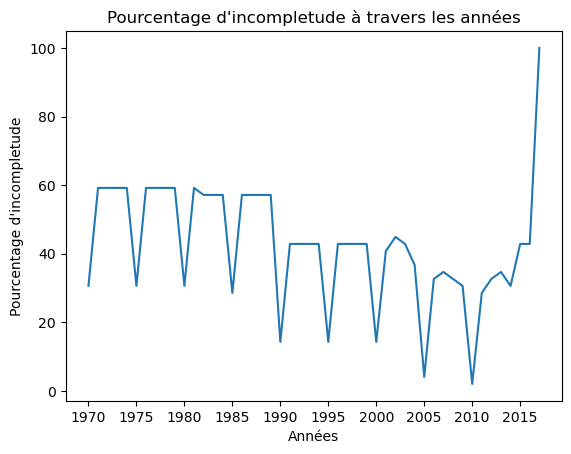

In [118]:
years = null_counts_annees.index
incomplete_percentage = null_counts_annees["% incompletude"]

plt.plot(years, incomplete_percentage)

plt.xticks(years[::5])

plt.xlabel("Années")
plt.ylabel("Pourcentage d'incompletude")
plt.title("Pourcentage d'incompletude à travers les années")

plt.show()

Le pourcentage d'incompletude est trop élevé et est inégal en fonction des années -> Analyse de l'évolution imprécise

In [119]:
EdStatsDataInterp = EdStatsDataFinal.iloc[:, :52]

df = EdStatsDataInterp

#Que des NaN pour 2017, on va l'enlever
df = df.iloc[:, 4:51]


In [120]:
for i in range(df.shape[0]):
    # Interpoler les valeurs manquantes
    df.iloc[i].interpolate(inplace=True)

In [121]:
df = df.dropna(axis=1)

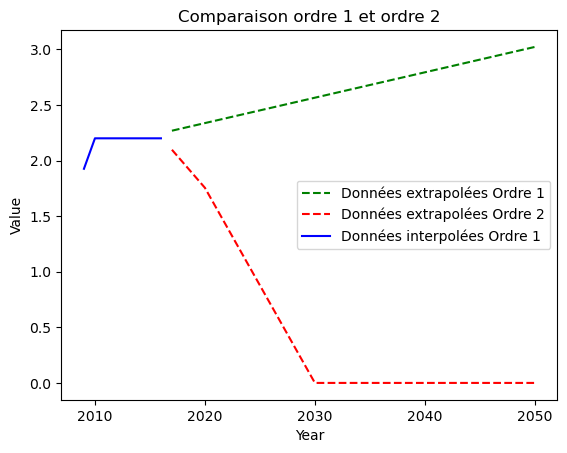

In [122]:
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2020, 2030, 2040, 2050]

Z = 8 # Le numero de ligne pour servir d'exemple 

for order in range(1, 3):
    order_df = extrapolate_values(order)
    values = order_df.iloc[Z].values
    if order == 1:
        values1 = values
    else:
        values2 = values

plt.plot(years[8:], values1[8:], 'g--', label='Données extrapolées Ordre 1')
plt.plot(years[8:], values2[8:], 'r--', label='Données extrapolées Ordre 2')
plt.plot(years[:8], values[:8], 'b', label='Données interpolées Ordre 1')

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Comparaison ordre 1 et ordre 2')
plt.legend()
plt.show()

Extrapolation ordre 1 à privilégier 

# Score attractivité (futur)

In [123]:
order_1 = extrapolate_values(1)
order_1 = order_1.iloc[:, -4:]

In [124]:
mask = (EdStatsData["Indicator Code"] == "SP.POP.GROW") | (EdStatsData["Indicator Code"] == "SP.POP.TOTL") | (
    EdStatsData["Indicator Code"] == "NY.GNP.PCAP.CD") | (EdStatsData["Indicator Code"] == "BAR.NOED.1519.ZS") |(
    EdStatsData["Indicator Code"] == "BAR.NOED.2024.ZS") | (EdStatsData["Indicator Code"] == "UIS.EA.6.AG25T99") |(
    EdStatsData["Indicator Code"] == "IT.NET.USER.P2")

EdStatsDataFinal = EdStatsData[mask]
EdStatsDataFinal 

EdStatsDataFinal = EdStatsDataFinal[EdStatsDataFinal['Country Name'].isin(country_names)]
EdStatsDataFinal = EdStatsDataFinal.iloc[:, :4]

In [125]:
EdStatsDataFinal = pd.concat([EdStatsDataFinal, order_1], axis=1) 

In [126]:
EdStatsDataFinal.rename(columns={2020: '2020', 2030: '2030', 2040: '2040', 2050: '2050'}, inplace=True)

In [127]:
pivot_table_final_rank = pivot_table_final["Rank"].to_frame()
pivot_table_final_rank

,Rank
Country Name,
Australia,1
Canada,2
Switzerland,3
United States,3
Denmark,5
Norway,6
Singapore,7


## 2020

In [128]:
# Création d'un dataframe pivot (Pays en lignes et Indicateurs en colonnes)
pivot_table = EdStatsDataFinal.pivot(index='Country Name', columns='Indicator Code', values='2020')

pivot_table_final = pivot_table
pivot_table_final

Indicator Code,BAR.NOED.1519.ZS,BAR.NOED.2024.ZS,IT.NET.USER.P2,NY.GNP.PCAP.CD,SP.POP.GROW,SP.POP.TOTL,UIS.EA.6.AG25T99
Country Name,,,,,,,
Australia,0.110,0.098,95.294654,72822.857143,1.127922,2.555250e+07,3.677117
Canada,0.000,2.337,95.692143,50629.285714,1.048402,3.778741e+07,48.681842
Denmark,0.000,2.068,104.287845,59323.928571,0.862486,5.825494e+06,9.625969
Norway,3.324,7.005,100.460983,97275.714286,0.739343,5.482046e+06,3.363465
Singapore,1.886,0.940,89.390759,64668.571429,0.220388,5.997714e+06,31.944955
Switzerland,3.822,0.000,93.133918,93803.571429,1.103677,8.730467e+06,5.688267
United States,0.181,0.108,77.876817,62902.500000,0.591555,3.324950e+08,2.773655


In [129]:
X = country_names.shape[0]

columns = ["BAR.NOED.1519.ZS", "BAR.NOED.2024.ZS"]

for col in columns:
    quantiles = pivot_table_final[col].quantile([(i+1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] < q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0
            
columns = ["NY.GNP.PCAP.CD", "SP.POP.GROW","SP.POP.TOTL", "IT.NET.USER.P2","UIS.EA.6.AG25T99"]
for col in columns:
    quantiles = pivot_table_final[col].quantile([(X-i-1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] > q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0

pivot_table_final = pivot_table_final.astype(int)
pivot_table_final = pivot_table_final.add(1)
pivot_table_final['Total'] = pivot_table_final.sum(axis=1)
pivot_table_final['Rank_2020'] = pivot_table_final['Total'].rank(ascending=False).astype(int)
pivot_table_final = pivot_table_final.sort_values(by='Total', ascending=False)
pivot_table_final = pivot_table_final.loc[['Australia', 'Canada', 'Switzerland', 'United States', 'Denmark', 'Norway', 'Singapore']]
pivot_table_final_2020= pivot_table_final["Rank_2020"].to_frame()
pivot_table_final_2020

,Rank_2020
Country Name,
Australia,1
Canada,2
Switzerland,3
United States,5
Denmark,4
Norway,7
Singapore,5


In [130]:
rank_final = pd.concat([pivot_table_final_rank,pivot_table_final_2020], axis=1) 
rank_final

,Rank,Rank_2020
Country Name,,
Australia,1,1
Canada,2,2
Switzerland,3,3
United States,3,5
Denmark,5,4
Norway,6,7
Singapore,7,5


## 2030

In [131]:
# Création d'un dataframe pivot (Pays en lignes et Indicateurs en colonnes)
pivot_table = EdStatsDataFinal.pivot(index='Country Name', columns='Indicator Code', values='2030')

pivot_table_final = pivot_table
pivot_table_final

Indicator Code,BAR.NOED.1519.ZS,BAR.NOED.2024.ZS,IT.NET.USER.P2,NY.GNP.PCAP.CD,SP.POP.GROW,SP.POP.TOTL,UIS.EA.6.AG25T99
Country Name,,,,,,,
Australia,0.110000,0.078000,114.189131,95613.333333,0.514836,2.907480e+07,0.000000
Canada,0.000000,2.565333,110.310000,54681.666667,0.987669,4.157693e+07,50.406002
Denmark,0.000000,1.114667,119.746969,56927.500000,1.307083,6.108498e+06,0.000000
Norway,3.780667,7.396667,107.896983,101806.666667,0.175137,6.070103e+06,0.000000
Singapore,2.096000,1.006667,108.087729,84865.000000,0.000000,6.899399e+06,40.036147
Switzerland,0.992000,0.000000,102.942867,110250.000000,1.066866,9.636007e+06,0.000000
United States,0.199333,0.104667,84.670839,76427.500000,0.368456,3.557261e+08,0.000000


In [132]:
X = country_names.shape[0]

columns = ["BAR.NOED.1519.ZS", "BAR.NOED.2024.ZS"]

for col in columns:
    quantiles = pivot_table_final[col].quantile([(i+1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] < q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0
            
columns = ["NY.GNP.PCAP.CD", "SP.POP.GROW","SP.POP.TOTL", "IT.NET.USER.P2","UIS.EA.6.AG25T99"]
for col in columns:
    quantiles = pivot_table_final[col].quantile([(X-i-1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] > q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0

pivot_table_final = pivot_table_final.astype(int)
pivot_table_final = pivot_table_final.add(1)
pivot_table_final['Total'] = pivot_table_final.sum(axis=1)
pivot_table_final['Rank_2030'] = pivot_table_final['Total'].rank(ascending=False).astype(int)
pivot_table_final = pivot_table_final.sort_values(by='Total', ascending=False)
pivot_table_final = pivot_table_final.loc[['Australia', 'Canada', 'Switzerland', 'United States', 'Denmark', 'Norway', 'Singapore']]
pivot_table_final_2030= pivot_table_final["Rank_2030"].to_frame()
pivot_table_final_2030

,Rank_2030
Country Name,
Australia,1
Canada,1
Switzerland,3
United States,5
Denmark,4
Norway,7
Singapore,5


In [133]:
rank_final = pd.concat([rank_final,pivot_table_final_2030], axis=1) 
rank_final

,Rank,Rank_2020,Rank_2030
Country Name,,,
Australia,1,1,1
Canada,2,2,1
Switzerland,3,3,3
United States,3,5,5
Denmark,5,4,4
Norway,6,7,7
Singapore,7,5,5


## 2040

In [134]:
# Création d'un dataframe pivot (Pays en lignes et Indicateurs en colonnes)
pivot_table = EdStatsDataFinal.pivot(index='Country Name', columns='Indicator Code', values='2040')

pivot_table_final = pivot_table
pivot_table_final

Indicator Code,BAR.NOED.1519.ZS,BAR.NOED.2024.ZS,IT.NET.USER.P2,NY.GNP.PCAP.CD,SP.POP.GROW,SP.POP.TOTL,UIS.EA.6.AG25T99
Country Name,,,,,,,
Australia,0.110000,0.058000,133.083608,118403.809524,0.000000,3.259709e+07,0.000000
Canada,0.000000,2.793667,124.927857,58734.047619,0.926937,4.536644e+07,52.130161
Denmark,0.000000,0.161333,135.206093,54531.071429,1.751681,6.391501e+06,0.000000
Norway,4.237333,7.788333,115.332983,106337.619048,0.000000,6.658160e+06,0.000000
Singapore,2.306000,1.073333,126.784699,105061.428571,0.000000,7.801084e+06,48.127338
Switzerland,0.000000,0.000000,112.751816,126696.428571,1.030055,1.054155e+07,0.000000
United States,0.217667,0.101333,91.464862,89952.500000,0.145358,3.789571e+08,0.000000


In [135]:
X = country_names.shape[0]

columns = ["BAR.NOED.1519.ZS", "BAR.NOED.2024.ZS"]

for col in columns:
    quantiles = pivot_table_final[col].quantile([(i+1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] < q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0
            
columns = ["NY.GNP.PCAP.CD", "SP.POP.GROW","SP.POP.TOTL", "IT.NET.USER.P2","UIS.EA.6.AG25T99"]
for col in columns:
    quantiles = pivot_table_final[col].quantile([(X-i-1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] > q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0

pivot_table_final = pivot_table_final.astype(int)
pivot_table_final = pivot_table_final.add(1)
pivot_table_final['Total'] = pivot_table_final.sum(axis=1)
pivot_table_final['Rank_2040'] = pivot_table_final['Total'].rank(ascending=False).astype(int)
pivot_table_final = pivot_table_final.sort_values(by='Total', ascending=False)
pivot_table_final = pivot_table_final.loc[['Australia', 'Canada', 'Switzerland', 'United States', 'Denmark', 'Norway', 'Singapore']]
pivot_table_final_2040= pivot_table_final["Rank_2040"].to_frame()
pivot_table_final_2040

,Rank_2040
Country Name,
Australia,3
Canada,2
Switzerland,1
United States,5
Denmark,4
Norway,7
Singapore,5


In [136]:
rank_final = pd.concat([rank_final,pivot_table_final_2040], axis=1) 
rank_final

,Rank,Rank_2020,Rank_2030,Rank_2040
Country Name,,,,
Australia,1,1,1,3
Canada,2,2,1,2
Switzerland,3,3,3,1
United States,3,5,5,5
Denmark,5,4,4,4
Norway,6,7,7,7
Singapore,7,5,5,5


## 2050

In [137]:
# Création d'un dataframe pivot (Pays en lignes et Indicateurs en colonnes)
pivot_table = EdStatsDataFinal.pivot(index='Country Name', columns='Indicator Code', values='2050')

pivot_table_final = pivot_table
pivot_table_final

Indicator Code,BAR.NOED.1519.ZS,BAR.NOED.2024.ZS,IT.NET.USER.P2,NY.GNP.PCAP.CD,SP.POP.GROW,SP.POP.TOTL,UIS.EA.6.AG25T99
Country Name,,,,,,,
Australia,0.110,0.038,151.978085,141194.285714,0.000000,3.611938e+07,0.000000
Canada,0.000,3.022,139.545714,62786.428571,0.866204,4.915595e+07,53.854321
Denmark,0.000,0.000,150.665218,52134.642857,2.196278,6.674505e+06,0.000000
Norway,4.694,8.180,122.768983,110868.571429,0.000000,7.246217e+06,0.000000
Singapore,2.516,1.140,145.481669,125257.857143,0.000000,8.702768e+06,56.218530
Switzerland,0.000,0.000,122.560765,143142.857143,0.993244,1.144709e+07,0.000000
United States,0.236,0.098,98.258884,103477.500000,0.000000,4.021882e+08,0.000000


In [138]:
X = country_names.shape[0]

columns = ["BAR.NOED.1519.ZS", "BAR.NOED.2024.ZS"]

for col in columns:
    quantiles = pivot_table_final[col].quantile([(i+1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] < q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0
            
columns = ["NY.GNP.PCAP.CD", "SP.POP.GROW","SP.POP.TOTL", "IT.NET.USER.P2","UIS.EA.6.AG25T99"]
for col in columns:
    quantiles = pivot_table_final[col].quantile([(X-i-1)/X for i in range(X-1)])
    for i, row in pivot_table_final.iterrows():
        for j, q in enumerate(quantiles):
            if row[col] > q:
                pivot_table_final.at[i, col] = X-(j+1)
                break
        else:
            pivot_table_final.at[i, col] = 0

pivot_table_final = pivot_table_final.astype(int)
pivot_table_final = pivot_table_final.add(1)
pivot_table_final['Total'] = pivot_table_final.sum(axis=1)
pivot_table_final['Rank_2050'] = pivot_table_final['Total'].rank(ascending=False).astype(int)
pivot_table_final = pivot_table_final.sort_values(by='Total', ascending=False)
pivot_table_final = pivot_table_final.loc[['Australia', 'Canada', 'Switzerland', 'United States', 'Denmark', 'Norway', 'Singapore']]
pivot_table_final_2050= pivot_table_final["Rank_2050"].to_frame()
pivot_table_final_2050

,Rank_2050
Country Name,
Australia,3
Canada,2
Switzerland,1
United States,6
Denmark,4
Norway,7
Singapore,5


In [139]:
rank_final = pd.concat([rank_final,pivot_table_final_2050], axis=1) 
rank_final

,Rank,Rank_2020,Rank_2030,Rank_2040,Rank_2050
Country Name,,,,,
Australia,1,1,1,3,3
Canada,2,2,1,2,2
Switzerland,3,3,3,1,1
United States,3,5,5,5,6
Denmark,5,4,4,4,4
Norway,6,7,7,7,7
Singapore,7,5,5,5,5


## Graphe futur

In [140]:
df = rank_final.reset_index(drop=False)
df.rename(columns={'Rank': '2010-2017',
                   'Rank_2020': '2020',
                   'Rank_2030': '2030',
                   'Rank_2040': '2040',
                   'Rank_2050': '2050'}, inplace=True)
df

,Country Name,2010-2017,2020,2030,2040,2050
0,Australia,1,1,1,3,3
1,Canada,2,2,1,2,2
2,Switzerland,3,3,3,1,1
3,United States,3,5,5,5,6
4,Denmark,5,4,4,4,4
5,Norway,6,7,7,7,7
6,Singapore,7,5,5,5,5


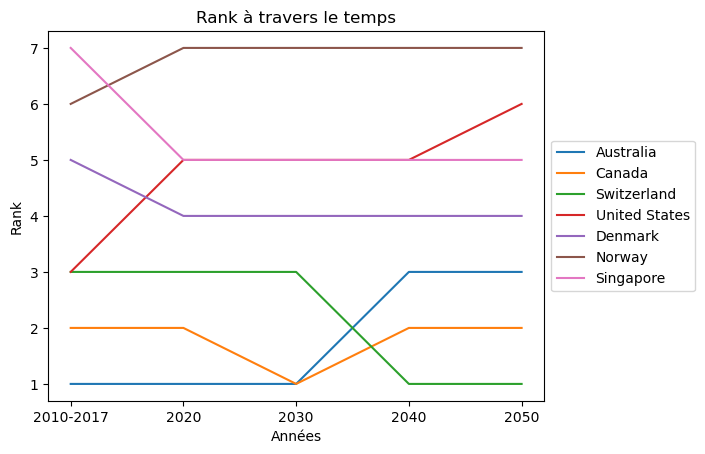

In [141]:
df.set_index('Country Name').transpose().plot(kind='line')
plt.xlabel('Années')
plt.ylabel('Rank')
plt.title('Rank à travers le temps')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(range(len(df.columns[1:])), df.columns[1:])
plt.show()